**Final Project**


Group 4 - Faiz Ahmed, Gonzalo Lara Jr, Andrew Lewis Nickerson, Kaevon Soleman, Antonio Sub Yun.

---


# Implementation (Code) 

In [1]:
#@title Dependencies
#!pip install aequitas
import pandas as pd
import seaborn as sns
#from aequitas.group import Group
#from aequitas.bias import Bias
#from aequitas.fairness import Fairness
#import aequitas.plot as ap
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion
from sklearn.model_selection import train_test_split

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Import Adult UCI Data and Create DataFrame
# Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 


train_url = '/content/drive/My Drive/Colab Notebooks/data/adult.data'
test_url = '/content/drive/My Drive/Colab Notebooks/data/adult.test'

original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

df = pd.concat([original_train, original_test]) # contaction of train and test data. merge test and train data together
df['Target'] = df['Target'].replace('<=50K.', '<=50K').replace('>50K.','>50K')
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#@title Logistic Regression Computations (helper functions)

# Helper function
def target_label_to_binary(df, t_value):
      '''
      Expects df to contain one column with two unique values.
      '''
      # Check that target_label columns has only two unique values
      # Also check that target value is one of the unique values
      unique_values = df.unique()

      if len(unique_values) > 2:
        raise Exception("Target column cannot be converted to binary, more than two unique values. Drop NA rows?")
      
      other_value = ''
      
      if unique_values[0] == t_value or unique_values[1] == t_value: 
        if unique_values[1] == t_value:
          other_value = unique_values[0]
        else: 
          other_value = unique_values[1]
      else:
        raise Exception("Target label value not present in df")

      df = df.replace(other_value, 0).replace(t_value, 1)

      return df

# from class -- credit to Dr. Mashhadi?
def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

def train_lgr_model_no_control(df, target_label, target_value, sensitive_attributes, test_partition=0.2):
      '''
      Creates a logistic regression model WITHOUT controlling for a feature.
      Returns a df in the format Aequitas wants.
      
      :param df: dataframe to run logistic regression on
      :param target_label: name of column to be converted to binary as y-variable
      :param target_value: value in target_label to be converted to 1
      :param sensitive_attributes: list of column name attributes you wish to analyze; gender, race, age, etc.
      :param test_partition: size of the testing data. default is 20%
      '''

      # Peel off y-variable and convert to binary
      y_data = df[target_label].astype(str)
      y_data = target_label_to_binary(y_data, target_value)

      # Peel off x-variables
      x_data = df.drop(columns = target_label)
      
      # Partition training and testing sets
      x_train , x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_partition)
      trainlength = len(x_train)

      # Use data_transform on the x variables
      x = pd.concat([x_train.copy(), x_test.copy()], axis=0)
      x = data_transform(x)

      # Fit logistic regression
      LR = linear_model.LogisticRegression(solver='liblinear', fit_intercept=True)
      LR.fit(x[:trainlength], y_train)
      LR_predictions = LR.predict(x[trainlength:])

      # Format model for Aequitas
      d = {'label_value' : y_test, 'score' : LR_predictions}

      AQ_req_columns = marginals = pd.DataFrame(data=d)
      model = pd.concat([x_test[sensitive_attributes], AQ_req_columns], axis=1)
     
      return model

After importing data to a df and defining the functions above, the block below provides a dataframe containing two simple logistic regression models preformated for Aequitas.

In [24]:
# df:                     dataframe imported above
# target_label:           column containing the feature that the model is predicting
# target value:           positive value for prediction, i.e., what categorical value of the target_label column should be 1
# sensitive_attributes:   list of columns of interest, i.e., ['Race', 'Gender', 'Age']
# test partition:         size of the test set, standard is 20% 
target_label = "Target"
target_value = "<=50K"
sensitive_attributes = ["Race", "Sex"] 
AQmodel1 = train_lgr_model_no_control(df, target_label, target_value, sensitive_attributes, test_partition=0.2)
AQmodel2 = train_lgr_model_no_control(df, target_label, target_value, sensitive_attributes, test_partition=0.15)
AQmodel1["model_id"] = 1
AQmodel2["model_id"] = 2
AQmodel = pd.concat([AQmodel1, AQmodel2], axis = 0)
display(AQmodel.head())
display(AQmodel.tail())

,Race,Sex,label_value,score,model_id
5576,White,Male,1,1,1
29982,White,Female,1,1,1
9814,White,Male,0,1,1
942,White,Female,1,1,1
15429,White,Female,1,1,1


,Race,Sex,label_value,score,model_id
3981,Asian-Pac-Islander,Male,0,1,2
10572,White,Male,1,1,2
5405,White,Male,0,0,2
12445,White,Male,0,0,2
5028,White,Female,1,1,2


## Aquitas Classes

The six following blocks contain the Aequitas source for each class. We made the following 4 modifications/contrubtations to the tool.


1.   Provide a binning method to group.py
2.   Provide a binning method for multiple models in group.py
3.   Modify preprocess_input_df to allow for 'score' and 'label_value' specifications for models (Issue #94)
4.   Add group size adjusted false positives/negatives to calculated absolute metrics in group.py and disparity functionality in bias.py (Issue #95)



In [6]:
#@title preprocessing.py
import logging
from sys import exit

import pandas as pd

logging.getLogger(__name__)

__author__ = "Rayid Ghani, Pedro Saleiro <saleiro@uchicago.edu>"
__copyright__ = "Copyright \xa9 2018. The University of Chicago. All Rights Reserved."

def check_required_cols(df, required_cols):
    """
    :param df: A data frame of model results
    :param required_cols: Column names required for selected fairness measures
    :return: None, or ValueError
    """
    check_model_cols = [col in df.columns for col in required_cols]
    if False in check_model_cols:
        raise ValueError
    return


def get_attr_cols(df, non_attr_cols):
    """
    :param df: A data frame of model results
    :param non_attr_cols: Names of columns not associated with attributes
    :return: List of columns associated with sample attributes
    """
    # index of the columns that are associated with attributes
    attr_cols = df.columns[~df.columns.isin(non_attr_cols)]
    if attr_cols.empty:
        raise ValueError
    return attr_cols.tolist()


def discretize(df, target_cols):
    """
    :param df: A data frame of model results
    :param target_cols: Names of columns to discretize
    :return: A data frame
    """
    for col in target_cols:
        if len(df[col].unique()) > 1:
            bins, values = pd.qcut(df[col], 4, precision=2, labels=False, duplicates='drop', retbins=True)
            try:
                df[col] = bins.map(lambda x: '%0.2f' % values[x] + '-' + '%0.2f' % values[x + 1])
            except Exception as e:
                logging.info('Something strange with a column in the input_df ' + str(e))
                df = df.drop(col)
        else:
            try:
                df[col] = df[col].astype(str)
            except Exception as e:
                logging.info('Something strange with a column in the input_df ' + str(e))
                df = df.drop(col)
    return df


def preprocess_input_df(df, required_cols=None, score=None, label_value=None):
    """
    :param df:            A data frame of model results
    :param required_cols: Names of columns required for bias calculations.
                          Default is None.
    :param score:         Name of predicted attribute column to be renamed to 'score'
    :param label_value:   Name of true attribute that is predicted to be renamed to 'label_value'
    :return: A data frame, list of columns associated with sample attributes
    """
    if not required_cols:
        required_cols = ['score']
    
    if score is not None or label_value is not None:
      try:
        df = df.rename({score: 'score', label_value: 'label_value'}, axis=1)
      except Exception as e:
                logging.info('preprocessing.preprocess_input_df: ' + str(e))

    try:
      check_required_cols(df, required_cols)
    except ValueError:
      logging.error('preprocessing.preprocess_input_df: input dataframe does not have all the required columns.')
    
      
    non_attr_cols = required_cols + ['model_id', 'as_of_date', 'entity_id', 'rank_abs', 'rank_pct', 'id', 'label_value']
    non_string_cols = df.columns[(df.dtypes != object) & (df.dtypes != str) & (~df.columns.isin(non_attr_cols))]
    df = discretize(df, non_string_cols)
    try:
        attr_cols_input = get_attr_cols(df, non_attr_cols)
    except ValueError:
        logging.error('preprocessing.preprocess_input_df: input dataframe does not have any other columns besides required '
                      'columns. Please add attribute columns to the input df.')
    return df, attr_cols_input

In [7]:
#@title group.py
import logging
import warnings
import pandas as pd
import numpy as np
logging.getLogger(__name__)

__author__ = "Rayid Ghani, Pedro Saleiro <saleiro@uchicago.edu>, Benedict Kuester, Loren Hinkson"
__copyright__ = "Copyright \xa9 2018. The University of Chicago. All Rights Reserved."


COLUMN_ORDER = ['model_id', 'score_threshold', 'k', 'attribute_name',
                'attribute_value', 'tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'gafp', 'gafn',
                'npv', 'precision', 'pp', 'pn', 'ppr', 'pprev', 'fp', 'fn',
                'tn', 'tp', 'group_label_pos', 'group_label_neg', 'group_size',
                'total_entities', 'prev']

class Group(object):
    """
    """
    all_group_metrics = ('ppr', 'pprev', 'precision', 'fdr', 'for', 'fpr',
                         'fnr', 'gafp', 'gafn', 'tpr', 'tnr', 'npv', 'prev')
    def __init__(self, input_group_metrics=all_group_metrics):
        """
        """
        self.absolute_metrics = input_group_metrics
        self.label_neg_count = lambda label_col: lambda x: \
            (x[label_col] == 0).sum()
        self.label_pos_count = lambda label_col: lambda x: \
            (x[label_col] == 1).sum()
        self.group_functions = self._get_group_functions()
        self.confusion_matrix_functions = self.get_confusion_matrix_functions()

    @staticmethod
    def get_confusion_matrix_functions():
        false_neg_count = lambda rank_col, label_col, thres, k: lambda x: \
            ((x[rank_col] > thres) & (x[label_col] == 1)).sum()

        false_pos_count = lambda rank_col, label_col, thres, k: lambda x: \
            ((x[rank_col] <= thres) & (x[label_col] == 0)).sum()

        true_neg_count = lambda rank_col, label_col, thres, k: lambda x: \
            ((x[rank_col] > thres) & (x[label_col] == 0)).sum()

        true_pos_count = lambda rank_col, label_col, thres, k: lambda x: \
            ((x[rank_col] <= thres) & (x[label_col] == 1)).sum()
        return {
            'fp': false_pos_count,
            'fn': false_neg_count,
            'tn': true_neg_count,
            'tp': true_pos_count
        }

    @staticmethod
    def _get_group_functions():
        """
        Helper function to accumulate lambda functions used in bias metrics
        calculations.
        """

        divide = lambda x, y: x / y if y != 0 else np.nan

        predicted_pos_count = lambda k: lambda x: x['fp'] + x['tp']

        predicted_neg_count = lambda k: lambda x: x['fn'] + x['tn']

        predicted_pos_ratio_k = lambda k: lambda x: divide(x['fp'] + x['tp'], k)

        predicted_pos_ratio_g = lambda k: lambda x: divide(
            x['fp'] + x['tp'], x['fn'] + x['tn'] + x['fp'] + x['tp']
        )

        fpr = lambda k: lambda x: divide(x['fp'], x['fp'] + x['tn'])

        tnr = lambda k: lambda x: divide(x['tn'], x['fp'] + x['tn'])

        fnr = lambda k: lambda x: divide(x['fn'], x['fn'] + x['tp'])

        tpr = lambda k: lambda x: divide(x['tp'], x['fn'] + x['tp'])

        fomr = lambda k: lambda x: divide(x['fn'], x['fn'] + x['tn'])

        npv = lambda k: lambda x: divide(x['tn'], x['fn'] + x['tn'])

        precision = lambda k: lambda x: divide(x['tp'], x['tp'] + x['fp'])

        fdr = lambda k: lambda x: divide(x['fp'], x['tp'] + x['fp'])

        gafp = lambda k: lambda x: divide(x['fp'],x['tp'] + x['tn'] + x['fp'] + x['fn'] )

        gafn = lambda k: lambda x: divide(x['fn'], x['tp'] + x['tn'] + x['fp'] + x['fn'] )

        group_functions = {'tpr': tpr,
                           'tnr': tnr,
                           'for': fomr,
                           'fdr': fdr,
                           'fpr': fpr,
                           'fnr': fnr,
                           'gafp': gafp,
                           'gafn': gafn,
                           'npv': npv,
                           'precision': precision,
                           'pp': predicted_pos_count,
                           'pn': predicted_neg_count,
                           'ppr': predicted_pos_ratio_k,
                           'pprev': predicted_pos_ratio_g,
                           }

        return group_functions


    def _check_model_id(self, df, method_table_name):
        if 'model_id' in df.columns:
            df_models = df.model_id.unique()
            if len(df_models) != 1:
                raise ValueError('This method requires one and only one model_id in the dataframe. '
                                 f'Tip: Check that {method_table_name}.model_id.unique() returns a one-element array. ')
            else:
                return df_models[0]
        else:
            return 0


    def get_multimodel_crosstabs(self, df, score_thresholds=None, attr_cols=None):
        """
        Calls `get_crosstabs()` for univariate groups and calculates group
        metrics for results from multiple models.
        :param df: a dataframe containing the following required columns [score,  label_value].
        :param score_thresholds: dictionary { 'rank_abs':[] , 'rank_pct':[], 'score':[] }
        :param attr_cols: optional, list of names of columns corresponding to
            group attributes (i.e., gender, age category, race, etc.).
        :return: A dataframe of group score, label, and error statistics and absolute bias metric values grouped by unique attribute values
        """
        if 'model_id' not in df.columns:
            raise ValueError("This method expects at least two distinct 'model_id' values "
                             f"in the dataframe. Tip: Check that 'df'' has a column called 'model_id.'")

        df_models = df.model_id.unique()
        crosstab_list = []

        if len(df_models) > 1:
            for model in df_models:
                model_df = df.loc[df['model_id'] == model]
                model_crosstab, model_attr_cols = self.get_crosstabs(model_df, score_thresholds=score_thresholds, attr_cols=attr_cols)
                crosstab_list.append(model_crosstab)

            # Note: only returns model_attr_cols from last iteration, as all will be same
            return pd.concat(crosstab_list, ignore_index=True), model_attr_cols
        else:
            return self.get_crosstabs(df, score_thresholds=score_thresholds, attr_cols=attr_cols)



    def get_crosstabs(self, df, score_thresholds=None, attr_cols=None):
        """
        Creates univariate groups and calculates group metrics for results
        from a single model.
        :param df: a dataframe containing the following required columns [score,  label_value].
        :param score_thresholds: dictionary { 'rank_abs':[] , 'rank_pct':[], 'score':[] }
        :param attr_cols: optional, list of names of columns corresponding to
            group attributes (i.e., gender, age category, race, etc.).
        :return: A dataframe of group score, label, and error statistics and absolute bias metric values grouped by unique attribute values
        """
        model_id = self._check_model_id(df, method_table_name='df')

        if not attr_cols:
            non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
            attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are

        df_cols = set(df.columns)
        # check if all attr_cols exist in df
        if len(set(attr_cols) - df_cols) > 0:
            raise Exception('get_crosstabs: not all attribute columns provided exist in input dataframe!')

        # check if all columns are strings:
        non_string_cols = df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]
        if non_string_cols.empty is False:
            raise Exception('get_crosstabs: input df was not preprocessed. There are non-string cols within attr_cols!')

        # if no score_thresholds are provided, we assume that rank_abs=number of 1s in the score column
        count_ones = None  # it also serves as flag to set parameter to 'binary'

        if not score_thresholds:
            df.loc[:, 'score'] = df.loc[:,'score'].astype(float)
            count_ones = df['score'].value_counts().get(1.0, 0)
            score_thresholds = {'rank_abs': [count_ones]}

        df = df.sort_values('score', ascending=False)
        df['rank_abs'] = range(1, len(df) + 1)
        df['rank_pct'] = df['rank_abs'] / len(df)
        dfs = []
        prior_dfs = []
        # calculate the bias for these columns
        # not default(non_attr_cols), therefore represent the group variables!
        logging.info('getcrosstabs: attribute columns to perform crosstabs:' + ','.join(attr_cols))
        # for each group variable do
        for col in attr_cols:
            # find the priors_df
            col_group = df.fillna({col: np.nan}).groupby(col)
            counts = col_group.size()
            # distinct entities within group value
            this_prior_df = pd.DataFrame({
                'model_id': [model_id] * len(counts),
                'attribute_name': [col] * len(counts),
                'attribute_value': counts.index.values,
                'group_label_pos': col_group.apply(self.label_pos_count(
                    'label_value')).values,
                'group_label_neg': col_group.apply(self.label_neg_count(
                    'label_value')).values,
                'group_size': counts.values,
                'total_entities': [len(df)] * len(counts)
            })
            this_prior_df['prev'] = this_prior_df['group_label_pos'] / this_prior_df['group_size']
            # for each model_id and as_of_date the priors_df has length
            # attribute_names * attribute_values
            prior_dfs.append(this_prior_df)

            # we calculate the bias for two different types of score_thresholds
            # units (percentage ranks and absolute ranks)
            # YAML ex: thresholds:
            #              rank_abs: [300]
            #              rank_pct: [0.01, 0.02, 0.05, 0.10]
            for thres_unit, thres_values in score_thresholds.items():

                for thres_val in thres_values:
                    flag = 0
                    k = (df[thres_unit] <= thres_val).sum()

                    # denote threshold as binary if numeric count_ones value
                    # donate as [rank value]_abs or [rank_value]_pct otherwise
                    score_threshold = 'binary 0/1' if count_ones != None else str(thres_val) + '_' + thres_unit[-3:]
                    for name, func in self.confusion_matrix_functions.items():
                        func = func(thres_unit, 'label_value', thres_val, k)
                        feat_bias = col_group.apply(func)
                        metrics_df = pd.DataFrame({
                            'model_id': [model_id] * len(feat_bias),
                            'score_threshold': [score_threshold] * len(feat_bias),
                            'k': [k] * len(feat_bias),
                            'attribute_name': [col] * len(feat_bias),
                            'attribute_value': feat_bias.index.values,
                            name: feat_bias.values
                        })
                        if flag == 0:
                            this_group_df = metrics_df
                            flag = 1
                        else:
                            this_group_df = this_group_df.merge(metrics_df)
                    for name, func in self.group_functions.items():
                        func = func(k)
                        feat_bias = this_group_df.apply(func, axis=1)
                        this_group_df[name] = feat_bias
                    dfs.append(this_group_df)
        groups_df = pd.concat(dfs, ignore_index=True)
        priors_df = pd.concat(prior_dfs, ignore_index=True)
        groups_df = groups_df.merge(priors_df, on=['model_id', 'attribute_name',
                                                   'attribute_value'])
        return groups_df[COLUMN_ORDER], attr_cols

    def get_binned_crosstabs(self, df, score_thresholds=None, bin_attr_cols=None, numerical_bin_by=None):
        '''
        :param df:                Dataframe to be binned and crosstabbed
        :param score_thresholds:  dictionary { 'rank_abs':[] , 'rank_pct':[], 'score':[] }
        :param bin_attr_cols:     Attributes to be binned together
        :param numerical_bin_by:  Dictionary specifying bin size and fence rounding for each numerical attribute
        '''
        # Check specified bin_attr_cols are columns of the dataframe
        if not bin_attr_cols:
            raise ValueError("Attribute columns to bin not specified. Binning all columns may not be desirable.")

        for val in bin_attr_cols:
          if val not in df.columns:
            raise Exception(val + " not found in df.")

        # Determine numerical and non-numerical bin_attr_cols columns
        numericals = [col for col in list(set(bin_attr_cols) 
                                              & set(df.select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])))] 
        
        nonnumericals = [col for col in list(set(bin_attr_cols)-set(numericals))]

        # if numerical columns and numerical_bin_by == None raise exception
        if len(numericals) == 0 and numerical_bin_by is not None:
          raise Exception("numerical_bin_by is not None but no numerical value columns provided in bin_attr_cols")

        # if numerical_bin_by != None and no numerical columns raise exception
        if len(numericals) > 0 and numerical_bin_by is None:
          raise ValueError("numerical_bin_by is None but a numerical value column provided in bin_attr_cols. Specify a partition size for numerical column.")

        # convert numerical columns to categorical and add to bins

        for attr in numericals:
          min_val = df[attr].min()
          max_val = df[attr].max()
          try:
            step = numerical_bin_by[attr][0]
            round_by = numerical_bin_by[attr][1]
          except Exception as e:
                logging.info('get_binned_crosstabs: Problem with partition dictionary for attribute column' + attr + ' -- ' + str(e))
          if round_by == 0:
            intervals = np.around(np.linspace(min_val, max_val, step, dtype='int'))
          else:
            intervals = np.around(np.linspace(min_val, max_val, step), round_by)
          cat_vals = [str(intervals[i]) + '-' + str(intervals[i+1]) for i in range(len(intervals)-1)]
          new_col_name = attr + " Binned"
          df[new_col_name] = pd.cut(df[attr], bins=intervals, labels=cat_vals, include_lowest=True)
          bin_attr_cols.append(new_col_name)
          bin_attr_cols.remove(attr)
          

        # create bins
        grouped_df = df.fillna(np.nan).groupby(bin_attr_cols)
        bins = [grouped_df.get_group(group).copy() for group in grouped_df.groups]
        for bin in bins:
          bin_name = " "
          bin_name = bin_name.join([col + ": " + bin[col].unique()[0] + "," for col in list(set(bin.columns) & set(bin_attr_cols))])
          bin["Binned Attributes"] = bin_name
          bin = bin.drop(nonnumericals, axis=1) # not working? but maybe we don't need to drop the other columns?

        return self.get_crosstabs(pd.concat((bin for bin in bins)), score_thresholds, ["Binned Attributes"])

    def get_multimodel_binned_crosstabs(self, df, score_thresholds=None, bin_attr_cols=None, numerical_bin_by=None):
        '''
        :param df:                Dataframe to be binned and crosstabbed, expecting df with 'model_id' column
        :param score_thresholds:  dictionary { 'rank_abs':[] , 'rank_pct':[], 'score':[] }
        :param bin_attr_cols:     Attributes to be binned together
        :param numerical_bin_by:  Partition size for numerical attributes
        '''

        if 'model_id' not in df.columns:
            raise ValueError("This method expects at least two distinct 'model_id' values "
                             f"in the dataframe. Tip: Check that 'df'' has a column called 'model_id.'")

        df_models = df.model_id.unique()
        crosstab_list = []

        if len(df_models) > 1:
            for model in df_models:
                model_df = df.loc[df['model_id'] == model]
                model_crosstab, model_attr_cols = self.get_binned_crosstabs(model_df, score_thresholds=score_thresholds, 
                                                                            bin_attr_cols=bin_attr_cols, numerical_bin_by=numerical_bin_by)
                crosstab_list.append(model_crosstab)

            # Note: only returns model_attr_cols from last iteration, as all will be same
            return pd.concat(crosstab_list, ignore_index=True), model_attr_cols
        
        else:
            return self.get_binned_crosstabs(df, score_thresholds=score_thresholds, bin_attr_cols=bin_attr_cols, numerical_bin_by=numerical_bin_by)

    def list_absolute_metrics(self, df):
        """
        View list of all calculated absolute bias metrics in df
        """
        return df.columns.intersection(self.absolute_metrics).tolist()

In [8]:
#@title squarify_flipped.py
'''
Attribution: Adapted from Uri Laserson's squaify source code for plotting treemaps in
matplotlib based on algorithm from Bruls, Huizing, van Wijk,
"Squarified Treemaps". (https://github.com/laserson/squarify)
Treemaps are flipped so smallest square is in bottom right corner. Added
function for plotting predefined rectangles. Made adjustments to treemap labeling.
'''

__author__ = "Pedro Saleiro <saleiro@uchicago.edu>, Loren Hinkson"
__copyright__ = "Copyright \xa9 2018. The University of Chicago. All Rights Reserved."

import matplotlib.pyplot as plt
import itertools

def normalize_sizes(sizes, dx, dy):
    '''
    Return list of normalized values corresponding to a list of supplied values
    and specified width (dx)/ height (dy) dimensions.
    :param sizes: Ordered (desc) list of values to be plotted as treemap squares
    :param dx: Total treemap width
    :param dy: Total treemap height
    :return: List of normalized values corresponding to original list
    '''
    total_size = sum(sizes)
    total_area = dx * dy
    sizes = map(float, sizes)
    sizes = map(lambda size: size * total_area / total_size, sizes)
    return list(sizes)


def layoutrow(sizes, x, y, dx, dy):
    '''
    Generate rectangle dimensions for each size in sizes when remaining width
    exceeds remaining height (dx >= dy). Rectangles will fill up height dy,
    and width will be determined by their area. Sizes should be pre-normalized
    with respect to dx * dy (i.e., they should be same units)
    :param sizes: Ordered (desc) ist of values normalized with respect to
        overall height (dy) and width values (dx)
    :param x: Rectangle start point on treemap x-axis
    :param y: Rectangle start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: List of dictionaries of rectangle dimensions
    '''
    covered_area = sum(sizes)
    width = covered_area / dy
    rects = []
    heights = 0
    for size in sizes:
        rects.append({'x': x, 'y': dy - (size / width), 'dx': width, 'dy': size / width})
        dy -= size / width
    return rects


def layoutcol(sizes, x, y, dx, dy):
    '''
    Generate rectangle dimensions for each size in sizes when remaining height
    exceeds remaining width (dx < dy). Rectangles will fill up width dx,
    and height will be determined by their area. Sizes should be pre-normalized
    with respect to dx * dy (i.e., they should be same units)
    :param sizes: List of values normalized with respect to overall height (dy)
        and width values (dx)
    :param x: Rectangle start point on treemap x-axis
    :param y: Rectangle start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: List of dictionaries of rectangle dimensions
    '''

    covered_area = sum(sizes)
    height = covered_area / dx
    rects = []
    for size in sizes:
        rects.append({'x': x, 'y': dy - height, 'dx': size / height, 'dy': height})
        x += size / height
    return rects


def layout(sizes, x, y, dx, dy):
    '''
    Call applicable helper function to generate dictionary of treemap rectangle
    dimensions based on relative width and height of remaining treemap area
    :param sizes: List of values normalized with respect to overall height (dy)
        and width values (dx)
    :param x: Rectangle start point on treemap x-axis
    :param y: Rectangle start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: List of dictionaries of rectangle dimensions
    '''
    return layoutrow(sizes, x, y, dx, dy) if dx >= dy else layoutcol(sizes, x, y, dx, dy)


def leftoverrow(sizes, x, y, dx, dy):
    '''
    Compute relative x-axis start, y-axis start, width, and height of overall
    treemap area when remaining width exceeds remaining height (dx >= dy)
    :param sizes: List of values normalized with respect to overall height (dy)
        and width values (dx)
    :param x: Remaining area start point on treemap x-axis
    :param y: Remaining area start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: Tuple of remaining area dimensions
    '''
    covered_area = sum(sizes)
    width = covered_area / dy
    leftover_x = x + width
    leftover_y = dy
    leftover_dx = dx - width
    leftover_dy = dy
    return (leftover_x, leftover_y, leftover_dx, leftover_dy)


def leftovercol(sizes, x, y, dx, dy):
    '''
    Compute relative x-axis start, y-axis start, width, and height of remaining
    treemap area when remaining height exceeds remaining width (dx < dy)
    :param sizes: List of values normalized with respect to overall height (dy)
        and width values (dx)
    :param x: Remaining area start point on treemap x-axis
    :param y: Remaining area start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: Tuple of remaining area dimensions
    '''
    covered_area = sum(sizes)
    height = covered_area / dx
    leftover_x = x
    leftover_y = dy
    leftover_dx = dx
    leftover_dy = dy - height
    return (leftover_x, leftover_y, leftover_dx, leftover_dy)


def leftover(sizes, x, y, dx, dy):
    '''
    Call applicable helper function to generate tuple of dimensions for
    remaining plottable area for rectangles
    :param sizes: List of values normalized with respect to overall height (dy)
        and width values (dx)
    :param x: Remaining area start point on treemap x-axis
    :param y: Remaining area start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: Tuple of remaining area dimensions
    '''
    return leftoverrow(sizes, x, y, dx, dy) if dx >= dy else leftovercol(sizes, x, y, dx, dy)


def worst_ratio(sizes, x, y, dx, dy):
    '''
    Calculate worst possible ratio between width (dx) and height (dy) to
    determine ideal layout for a given list of rectangle dimensions
    :param sizes: List of values normalized with respect to overall height (dy)
        and width values (dx)
    :param x: Remaining area start point on treemap x-axis
    :param y: Remaining area start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: Numeric value indicating worst ratio between height/width
        dimensions
    '''
    return max(
        max(
            rect['dx'] / rect['dy'],
            rect['dy'] / rect['dx']
            )
        for rect in layout(sizes, x, y, dx, dy)
    )


def squarify(sizes, x, y, dx, dy):
    """
    Calculate rectangle dimensions for list of values relative to a given
    width (dx) and height (dy), starting at given x-axis and y-axis values.
    List 'sizes' must be normalized, unless dx * dy == sum(sizes).
    :param sizes: Ordered (desc) list of values normalized with respect to
        overall height (dy) and width values (dx)
    :param x: Remaining area start point on treemap x-axis
    :param y: Remaining area start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: List of dictionaries of rectangle dimensions
    """
    sizes = list(map(float, sizes))

    if len(sizes) == 0:
        return []

    if len(sizes) == 1:
        return layout(sizes, x, y, dx, dy)

    # figure out where 'split' should be based on utilization of remaining area
    # determined by ratio between width (dx) and height (dy)
    i = 1
    while i < len(sizes) and worst_ratio(sizes[:i], x, y, dx, dy) >= worst_ratio(sizes[:(i + 1)], x, y, dx, dy):
        i += 1
    current = sizes[:i]

    remaining = sizes[i:]

    (leftover_x, leftover_y, leftover_dx, leftover_dy) = leftover(current, x, y, dx, dy)

    return layout(current, x, y, dx, dy) + \
       squarify(remaining, leftover_x, leftover_y, leftover_dx, leftover_dy)


def pad_rectangle(rect):
    '''
    Decrease rectangle dimensions to show whitespace in treemap
    :param rect: Dictionary of rectangle dimensions to be decreased to enable
        whitespace padding in treemap visualization
    :return: Dictionary of updated rectangle dimensions
    '''
    if rect['dx'] > 2:
        rect['x'] += 1
        rect['dx'] -= 2
    if rect['dy'] > 2:
        rect['y'] += 1
        rect['dy'] -= 2


def padded_squarify(sizes, x, y, dx, dy):
    '''
    Calculate rectangle dimensions relative to a given width (dx) and height (dy)
    starting at given x-axis and y-axis values, leaving room for whitespace
    padding between treemap rectangles
    :param sizes: Ordered (desc) list of values normalized with respect to
        overall height (dy) and width values (dx)
    :param x: Remaining area start point on treemap x-axis
    :param y: Remaining area start point on treemap y-axis
    :param dx: Remaining treemap width
    :param dy: Remaining treemap height
    :return: List of dictionaries of rectangle dimensions
    '''
    rects = squarify(sizes, x, y, dx, dy)
    for rect in rects:
        pad_rectangle(rect)
    return rects

def squarify_plot_rects(rects, norm_x=100, norm_y=100, color=None,
                        labels=None, values=None, ax=None, acronyms = False, **kwargs):
    """
    Plotting with Matplotlib from predefined rectangles. Adapted from squarify
    source code.
    :param rects: list-like of dictionaries indicating rectangle dimensions
        for plotting
    :param norm_x:  overall figure dimensions for normalizing value box sizes
    :param norm_y: overall figure dimensions for normalizing value box sizes
    :param color: color string or list-like of colors to use for value boxes
    :param labels: list-like used as label text
    :param values: list-like used as value text
    :param ax: Matplotlib Axes instance
    :param kwargs: dict, keyword arguments passed to matplotlib.Axes.bar
    :return: matplotlib.Axis
    """
    x = [rect['x'] for rect in rects]
    y = [rect['y'] for rect in rects]
    dx = [rect['dx'] for rect in rects]
    dy = [rect['dy'] for rect in rects]

    ax.bar(x, dy, width=dx, bottom=y, color=color,
           label=labels, align='edge', **kwargs)

    INDENT_LENGTH = 4
    CHAR_PLACEHOLDER = 1.5

    if values is not None:
        va = 'center' if labels is None else 'top'
        if values:
            plot_ready_values = [
                val if isinstance(val, str)
                else f"{val:.2}" if isinstance(val, (int, float))
                else ""
                for val in values
            ]

        for val, r in zip(plot_ready_values, rects):
            x, y, dx, dy = r['x'], r['y'], r['dx'], r['dy']

            # if box large enough, add labels and values
            if (dx >= (INDENT_LENGTH * 2) + (CHAR_PLACEHOLDER * len(val))) &\
                    (dx > 10):
                ax.text(x + dx / 2, y + dy / 2, val, va=va,
                        ha='center', fontsize=12)

    if labels is not None:
        va = 'center' if values is None else 'bottom'
        under_plot = []
        alphabet = list(map(chr, range(65, 91)))
        under_plot_num = 0

        if values:
            plot_ready_values = [
                val if isinstance(val, str)
                else f"{val:.2}" if isinstance(val, (int, float))
                else ""
                for val in values
            ]
        else:
            plot_ready_values = itertools.repeat(None)

        for (label, r, val) in zip(labels, rects, plot_ready_values):
            x, y, dx, dy = r['x'], r['y'], r['dx'], r['dy']
            length = dx

            # if box large enough, add labels and values
            if (dx >= (INDENT_LENGTH * 2) + CHAR_PLACEHOLDER * len(label)) & (dx > 10):
                ax.text(x + dx / 2, y + dy / 2, label, va=va, ha='center',
                        fontsize=14, wrap=False)


            else:
                # add labels that don't fit in boxes underneath plot
                if acronyms:
                    # use acronym to to label very small boxes
                    acronym = ''.join([word[0] for word in str(label).split(' ')])

                    # add labels that don't fit in boxes underneath plot
                    ax.text(x + dx / 2, y + dy / 2, acronym, va=va,
                            ha='center', fontsize=12, wrap=False)

                    underplot_label = str(label) if val is None else f"{label}, {val}"
                    under_plot.append(f"{acronym}: {underplot_label}")

                else:
                    # use alphabet character to to label very small boxes
                    ax.text(x + dx / 2, y + dy / 2, alphabet[under_plot_num], va=va,
                            ha='center', fontsize=12, wrap=False)

                    underplot_label = str(label) if val is None else f"{label}, {val}"
                    under_plot.append(f"{alphabet[under_plot_num]}: {underplot_label}")
                    under_plot_num += 1


        if len(under_plot) > 0:
            unlabeled = ('\n').join(under_plot)
            ax.text(0.0, -0.05, f"Not labeled above:\n{unlabeled}",
                    ha='left', va='top', transform=ax.transAxes, fontsize=14)

    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)
    return ax

In [9]:
#@title plotting.py
import logging
import math
import numpy as np
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

#from aequitas import squarify_flipped as sf

logging.getLogger(__name__)

__author__ = "Pedro Saleiro <saleiro@uchicago.edu>, Loren Hinkson"
__copyright__ = "Copyright \xa9 2018. The University of Chicago. All Rights Reserved."



# module-level function
def assemble_ref_groups(disparities_table, ref_group_flag='_ref_group_value',
                         specific_measures=None, label_score_ref=None):
    """
    Creates a dictionary of reference groups for each metric in a data_table.
   :param disparities_table: a disparity table. Output of bias.get_disparity or
        fairness.get_fairness functions
    :param ref_group_flag: string indicating column indicates reference group
        flag value. Default is '_ref_group_value'.
    :param specific_measures: Limits reference dictionary to only specified
        metrics in a data table. Default is None.
    :param label_score_ref: Defines a metric, ex: 'fpr' (false positive rate)
        from which to mimic reference group for label_value and score. Used for
        statistical significance calculations in Bias() class. Default is None.
    :return: A dictionary
    """
    ref_groups = {}
    ref_group_cols = \
        set(disparities_table.columns[disparities_table.columns.str.contains(
            ref_group_flag)])

    # Note: specific measures is a set
    if specific_measures:
        if len(specific_measures) < 1:
            raise ValueError("At least one metric must be passed for which to "
                             "find refrence group.")

        specific_measures = specific_measures.union({label_score_ref})
        ref_group_cols = {measure + ref_group_flag for measure in specific_measures if
             measure + ref_group_flag in ref_group_cols}

    attributes = list(disparities_table.attribute_name.unique())

    for attribute in attributes:
        attr_table = \
            disparities_table.loc[disparities_table['attribute_name'] == attribute]

        attr_refs = {}
        for col in ref_group_cols:
            if col in ('label' + ref_group_flag, 'score' + ref_group_flag):
                continue

            metric_key = col.replace(ref_group_flag, '')
            attr_refs[metric_key] = \
                attr_table.loc[attr_table['attribute_name'] == attribute, col].min()
        if label_score_ref:
            is_valid_label_ref = lambda label: label + ref_group_flag in disparities_table.columns

            if not is_valid_label_ref(label_score_ref):
                try:
                    label_score_ref = next(measure for measure in specific_measures if is_valid_label_ref(measure))
                    logging.warning("The specified reference measure for label "
                                    "value and score is not included in the "
                                    f"data frame. Using '{label_score_ref}' "
                                    "reference group as label value and score "
                                    "reference instead.")

                except StopIteration:
                    raise ValueError("None of metrics passed in 'specific_measures' are in dataframe.")

            attr_refs['label_value'] = attr_refs[label_score_ref]
            attr_refs['score'] = attr_refs[label_score_ref]

        ref_groups[attribute] = attr_refs

    return ref_groups


# Plot() class
class Plot(object):
    """
    Plotting object allows for visualization of absolute group bias metrics and
    relative disparities calculated by Aequitas Group(), Bias(), and Fairness()
    class instances.
    """
    default_absolute_metrics = ('pprev', 'ppr', 'fdr', 'for', 'fpr', 'fnr')
    default_disparities = ('pprev_disparity', 'ppr_disparity',
                           'fdr_disparity', 'for_disparity',
                           'fpr_disparity', 'fnr_disparity')

    # Define mapping for conditional coloring based on fairness
    # determinations
    _metric_parity_mapping = {
        'ppr_disparity': 'Statistical Parity',
        'pprev_disparity': 'Impact Parity',
        'precision_disparity': 'Precision Parity',
        'fdr_disparity': 'FDR Parity',
        'for_disparity': 'FOR Parity',
        'fpr_disparity': 'FPR Parity',
        'fnr_disparity': 'FNR Parity',
        'tpr_disparity': 'TPR Parity',
        'tnr_disparity': 'TNR Parity',
        'npv_disparity': 'NPV Parity',
        'ppr': 'Statistical Parity',
        'pprev': 'Impact Parity',
        'precision': 'Precision Parity',
        'fdr': 'FDR Parity',
        'for': 'FOR Parity',
        'fpr': 'FPR Parity',
        'fnr': 'FNR Parity',
        'tpr': 'TPR Parity',
        'tnr': 'TNR Parity',
        'npv': 'NPV Parity'
    }

    _significance_disparity_mapping = {
        'ppr_disparity': 'ppr_significance',
        'pprev_disparity': 'pprev_significance',
        'precision_disparity': 'precision_significance',
        'fdr_disparity': 'fdr_significance',
        'for_disparity': 'fnr_significance',
        'fpr_disparity': 'fpr_significance',
        'fnr_disparity': 'fnr_significance',
        'tpr_disparity': 'tpr_significance',
        'tnr_disparity': 'tnr_significance',
        'npv_disparity': 'npv_significance'
    }

    def __init__(self, key_metrics=default_absolute_metrics,
                 key_disparities=default_disparities):
        """
        :param key_metrics: Set default absolute group metrics for all subplots
        :param key_disparities: Set default disparity metrics for all subplots
        """
        self.key_metrics = key_metrics
        self.key_disparities = key_disparities

    @staticmethod
    def _nearest_quartile(x):
        '''
        Return nearest quartile for given value x.
        '''
        rounded = round(x * 4) / 4
        if rounded > x:
            return rounded
        else:
            return rounded + 1 / 4

    @staticmethod
    def _check_brightness(rgb_tuple):
        '''
        Determine the brightness of background color in a plot.
        Adapted from https://trendct.org/2016/01/22/how-to-choose-a-label-color-to-contrast-with-background/
        '''
        r, g, b = rgb_tuple
        return (r * 299 + g * 587 + b * 114) / 1000

    @classmethod
    def _brightness_threshold(cls, rgb_tuple, min_brightness, light_color,
                             dark_color='black'):
        '''
        Determine ideal plot label color (light or dark) based on brightness of
        background color based on a given brightness threshold.
        Adapted from https://trendct.org/2016/01/22/how-to-choose-a-label-color-to-contrast-with-background/
        '''
        if cls._check_brightness(rgb_tuple) > min_brightness:
            return dark_color

        return light_color

    @staticmethod
    def _truncate_colormap(orig_cmap, min_value=0.0, max_value=1.0, num_colors=100):
        '''
        Use only part of a colormap (min_value to max_value) across a given number
        of partitions.
        :param orig_cmap: an existing Matplotlib colormap.
        :param min_value: desired minimum value (0.0 to 1.0) for truncated
            colormap. Default is 0.0.
        :param max_value: desired maximum value (0.0 to 1.0) for truncated
            colormap. Default is 1.0.
        :param num_colors: number of colors to spread colormap gradient across
            before truncating. Default is 100.
        :return: Truncated color map
        Attribution: Adapted from: https://stackoverflow.com/questions/
        18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
        '''
        cmap = plt.get_cmap(orig_cmap)
        new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b: .2f})'.format(n=cmap.name, a=min_value, b=max_value),
            cmap(np.linspace(min_value, max_value, num_colors)))
        return new_cmap


    @classmethod
    def _locate_ref_group_indices(cls, disparities_table, attribute_name, group_metric,
                                 ref_group_flag='_ref_group_value'):
        """
        Finds relative index (row) of reference group value for a given metric.
        :param disparities_table: a disparity table. Output of bias.get_disparity or
            fairness.get_fairness functions.
        :param attribute_name: the attribute to plot metric against. Must be a column
            in the disparities_table.
        :param group_metric: the metric to plot. Must be a column in the
            disparities_table.
        :param ref_group_flag: string indicating column indicates reference group
            flag value. Default is '_ref_group_value'.
        :return: Integer indicating relative index of reference group value row.
        """
        df_models = disparities_table.model_id.unique()
        if len(df_models) == 1:
            model_id = df_models[0]
        else:
            raise ValueError('This method requires one and only one model_id in the disparities table. '
                             'Tip: check disparities_table.model_id.unique() should be just one element list.')
        # get absolute metric name from passed group metric (vs. a disparity name)
        abs_metric = group_metric.replace('_disparity', '')

        all_ref_groups = assemble_ref_groups(disparities_table, ref_group_flag)
        ref_group_name = all_ref_groups[attribute_name][abs_metric]

        # get index for row associated with reference group for that model
        ind = list(disparities_table.loc[(disparities_table['attribute_name'] == attribute_name) &
                                         (disparities_table['attribute_value'] == ref_group_name) &
                                         (disparities_table['model_id'] == model_id)].index)

        # there should only ever be one item in list, but JIC, select first
        if len(ind) == 1:
            idx = ind[0]
        else:
            raise ValueError(f"failed to find only one index for the reference "
                             f"group for attribute_name = {attribute_name} and "
                             f"attribute_value of reference = {ref_group_name} "
                             f"and model_id={model_id}")

        relative_ind = disparities_table.index.get_loc(idx)
        return relative_ind, ref_group_name



    @staticmethod
    def iterate_subplots(axs, ncols, rows, ax_col, ax_row):
        ax_col += 1

        if (ax_col >= ncols) and ((ax_col + 1) % ncols) == 1:
            ax_row += 1
            ax_col = 0

        if rows == 1:
            current_subplot = axs[ax_col]

        elif ncols == 1:
            current_subplot = axs[ax_row]
            ax_row += 1
        else:
            current_subplot = axs[ax_row, ax_col]

        return current_subplot, ax_row, ax_col



    @staticmethod
    def generate_axes(ncols, num_metrics, total_plot_width, sharey, hspace=0.25, indiv_height=6):
        rows = math.ceil(num_metrics / ncols)

        if ncols == 1 or (num_metrics % ncols == 0):
            axes_to_remove = 0
        else:
            axes_to_remove = ncols - (num_metrics % ncols)

        if not (0 < rows <= num_metrics):
            raise ValueError(
                "Plot must have at least one row. Please update number of columns"
                " ('ncols') or check that at least one metric is specified in "
                "'metrics'.")
        if not (0 < ncols <= num_metrics):
            raise ValueError(
                "Plot must have at least one column, and no more columns than "
                "subplots. Please update number of columns ('ncols') or check "
                "that at least one metric is specified in 'metrics'.")

        total_plot_width = total_plot_width

        fig, axs = plt.subplots(nrows=rows, ncols=ncols,
                                figsize=(total_plot_width, indiv_height * rows),
                                sharey=sharey,
                                gridspec_kw={'wspace': 0.075, 'hspace': hspace})

        return fig, axs, rows, axes_to_remove



    def multimodel_plot_group_metric(self, group_table, group_metric,
                                     ncols=3, title=True, label_dict=None,
                                     show_figure=True, selected_models=None,
                                     min_group_size = None):
        """
        Plot a single group metric across all attribute groups for multiple models.
        :param group_table: group table. Output of of group.get_crosstabs() or
            bias.get_disparity functions.
        :param group_metric: the metric to plot. Must be a column in the group_table.
        :param ncols: The number of subplots to plot per row visualization
            figure.
            Default is 3.
        :param title: whether to include a title in visualizations. Default is True.
        :param label_dict: optional, dictionary of replacement labels for data.
            Default is None.
        :param show_figure: Whether to show figure (plt.show()). Default is
            True.
        :param selected_models: which models to visualize. Default is all models in group_table.
        :param min_group_size: minimum size for groups to include in visualization
            (as a proportion of total sample).
        :return: A Matplotlib axis
        """
        # requirement: at least two model_id values
        df_models = self._check_multiple_models(group_table, method_table_name='group_table')

        if not selected_models:
            selected_models = df_models

        plot_table = group_table.loc[group_table['model_id'].isin(selected_models)]


        num_metrics = len(df_models)

        total_plot_width = 25

        fig, axs, rows, axes_to_remove = self.generate_axes(ncols=ncols, num_metrics=num_metrics,
                                                       total_plot_width=total_plot_width, sharey=True)

        # set a different distribution to be plotted in each subplot
        ax_col = -1
        ax_row = 0
        col_num = 0

        for model in df_models:

            if plot_table.loc[plot_table['model_id'] == model, group_metric].isnull().all():
                logging.warning(f"Cannot plot metric '{group_metric}', only NaN values.")
                axes_to_remove += 1
                continue

            elif plot_table.loc[plot_table['model_id'] == model, group_metric].isnull().any():
                # determine which group(s) have missing values
                missing = ", ".join(plot_table.loc[(plot_table['model_id'] == model) &
                                                    (plot_table[
                                                         group_metric].isnull()), 'attribute_value'].values.tolist())

                attr = ", ".join(plot_table.loc[(plot_table['model_id'] == model) &
                                                 (plot_table[
                                                      group_metric].isnull()), 'attribute_name'].values.tolist())

                logging.warning(f"Model {model} '{attr}' group '{missing}' value for metric "
                                f"'{group_metric}' is NA, group not included in visualization.")
                plot_table = plot_table.dropna(axis=0, subset=[group_metric])

                model_table = plot_table.loc[plot_table['model_id'] == model]

            else:
                model_table = plot_table.loc[plot_table['model_id'] == model]

            current_subplot, ax_row, ax_col = self.iterate_subplots(axs, ncols, rows, ax_col, ax_row)

            self.plot_group_metric(group_table=model_table, group_metric=group_metric,
                                   ax=current_subplot, ax_lim=None, title=title, label_dict=label_dict,
                                   min_group_size = min_group_size)

            if title:
                current_subplot.set_title(f"{group_metric.upper()} (Model {model})", fontsize=20)

            col_num += 1

        # disable axes not being used
        if axes_to_remove > 0:
            for i in np.arange(axes_to_remove):
                axs[-1, -(i + 1)].axis('off')

        if show_figure:
            plt.show()

        return fig


    def multimodel_plot_fairness_group(self, fairness_table, group_metric,
                               ncols=3, title=True, label_dict=None, show_figure=True,
                               selected_models=None, min_group_size = None):
        """
        Plot a single group metric colored by parity determination across all
        attribute groups for multiple models.
        :param fairness_table: a fairness table. Output of a Fairness.get_fairness
            function.
        :param group_metric: the metric to plot. Must be a column in the group_table.
        :param ncols: The number of subplots to plot per row visualization
            figure.
            Default is 3.
        :param title: whether to include a title in visualizations. Default is True.
        :param label_dict: optional, dictionary of replacement labels for data.
            Default is None.
        :param show_figure: Whether to show figure (plt.show()). Default is
            True.
        :param selected_models: which models to visualize. Default is all models in fairness_table.
        :param min_group_size: minimum size for groups to include in visualization
            (as a proportion of total sample)
        :return: A Matplotlib axis
        """
        parity_list = list(fairness_table.columns[fairness_table.columns.str.contains(' Parity')])
        if len(parity_list) < 1:
            raise ValueError("multimodel_plot_fairness_disparity: No parity determinations found in fairness_table.")

        # requires at least 2 models
        df_models = self._check_multiple_models(fairness_table, method_table_name='fairness_table')

        if not selected_models:
            selected_models = df_models

        plot_table = fairness_table.loc[fairness_table['model_id'].isin(selected_models)]

        num_metrics = len(df_models)

        total_plot_width = 25

        fig, axs, rows, axes_to_remove = self.generate_axes(ncols=ncols, num_metrics=num_metrics,
                                                       total_plot_width=total_plot_width, sharey=True)

        # set a different distribution to be plotted in each subplot
        ax_col = -1
        ax_row = 0
        col_num = 0

        viz_title = \
            f"MODEL COMPARISON: {group_metric.replace('_', ' ').upper()} PARITY"

        for model in df_models:

            if plot_table.loc[plot_table['model_id'] == model, group_metric].isnull().all():
                logging.warning(f"Cannot plot metric '{group_metric}', only NaN values.")
                axes_to_remove += 1
                continue

            elif plot_table.loc[plot_table['model_id'] == model, group_metric].isnull().any():
                # determine which group(s) have missing values
                missing = ", ".join(plot_table.loc[(plot_table['model_id'] == model) &
                                                       (plot_table[
                                                            group_metric].isnull()), 'attribute_value'].values.tolist())

                attr = ", ".join(plot_table.loc[(plot_table['model_id'] == model) &
                                                    (plot_table[
                                                         group_metric].isnull()), 'attribute_name'].values.tolist())

                logging.warning(f"Model {model} '{attr}' group '{missing}' value for metric "
                                f"'{group_metric}' is NA, group not included in visualization.")

                plot_table = plot_table.dropna(axis=0, subset=[group_metric])

                model_table = plot_table.loc[plot_table['model_id'] == model]

            else:
                model_table = plot_table.loc[plot_table['model_id'] == model]

            current_subplot, ax_row, ax_col = self.iterate_subplots(axs, ncols, rows, ax_col, ax_row)

            self.plot_fairness_group(fairness_table=model_table, group_metric=group_metric,
                                   ax=current_subplot, ax_lim=None, title=title, label_dict=label_dict,
                                   min_group_size = min_group_size)

            if title:
                current_subplot.set_title(f"{group_metric.upper()} (Model {model})", fontsize=20)


            col_num += 1

        # disable axes not being used
        if axes_to_remove > 0:
            for i in np.arange(axes_to_remove):
                axs[-1, -(i + 1)].axis('off')

        if title:
            plt.suptitle(f"{viz_title}", fontsize=25, fontweight="bold")

        if show_figure:
            plt.show()

        return fig


    def multimodel_plot_disparity(self, disparity_table, group_metric,
                                  attribute_name, color_mapping=None,
                                  label_dict=None, title=True, show_figure=True,
                                  highlight_fairness=True, selected_models=None,
                                  min_group_size=None, significance_alpha=0.05):
        """
        Create treemaps to compare multiple model values for a single bias
        disparity metric across attribute groups.
        Adapted from https://plot.ly/python/treemaps/,
        https://gist.github.com/gVallverdu/0b446d0061a785c808dbe79262a37eea,
        and https://fcpython.com/visualisation/python-treemaps-squarify-matplotlib
        :param disparity_table: a disparity table. Output of bias.get_disparity or
            fairness.get_fairness function.
        :param group_metric: the metric to plot. Must be a column in the
            disparity_table.
        :param attribute_name: which attribute to plot group_metric across.
        :param color_mapping: matplotlib colormapping for treemap value boxes.
        :param label_dict: optional, dictionary of replacement labels for data.
            Default is None.
        :param title: whether to include a title in visualizations. Default is True.
        :param highlight_fairness: whether to highlight treemaps by disparity
            magnitude, or by related fairness determination.
        :param show_figure: Whether to show figure (plt.show()). Default is
            True.
        :param selected_models: which models to visualize. Default is all models in disparity_table.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in bias metric
            visualization.
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap).
        :return: A Matplotlib figure
        """
        # requires at least 2 models
        df_models = self._check_multiple_models(disparity_table, method_table_name='disparity_table')

        if not selected_models:
            selected_models = df_models

        plot_table = disparity_table.loc[disparity_table['model_id'].isin(selected_models)]

        if group_metric + '_disparity' not in plot_table.columns:
            related_disparity = group_metric

        else:
            related_disparity = group_metric + '_disparity'

        viz_title = \
            f"MODEL COMPARISON: {related_disparity.replace('_', ' ').upper()}"

        num_metrics = len(df_models)
        ncols=3
        total_plot_width = 25

        fig, axs, rows, axes_to_remove = self.generate_axes(
            ncols=ncols, num_metrics=num_metrics, total_plot_width=total_plot_width,
            sharey=True, hspace=0.5, indiv_height=8)

        # set a different distribution to be plotted in each subplot
        ax_col = -1
        ax_row = 0
        col_num = 0

        for model in df_models:
            model_table = plot_table.loc[plot_table['model_id'] == model]

            current_subplot, ax_row, ax_col = self.iterate_subplots(axs, ncols, rows, ax_col, ax_row)

            self.plot_disparity(model_table, group_metric=group_metric,
                                attribute_name=attribute_name, color_mapping=color_mapping,
                                ax=current_subplot, fig=fig, label_dict=label_dict,
                                title=title, highlight_fairness=highlight_fairness,
                                min_group_size=min_group_size,
                                significance_alpha=significance_alpha)
            if title:
                current_subplot.set_title(f"{related_disparity.replace('_', ' ').upper()}: {attribute_name.upper()} (Model {model})",
                                 fontsize=23)


            col_num += 1

        # disable axes not being used
        if axes_to_remove > 0:
            for i in np.arange(axes_to_remove):
                axs[-1, -(i + 1)].axis('off')

        if title:
            plt.suptitle(f"{viz_title}", fontsize=25, fontweight="bold")

        if show_figure:
            plt.show()

        return fig




    def multimodel_plot_fairness_disparity(self, fairness_table, group_metric,
                                           attribute_name, label_dict=None,
                                           title=True, show_figure=True, selected_models=None,
                                           min_group_size=None, significance_alpha=0.05):
        """
        Create treemaps to compare multiple model fairness determinations for a
        single bias disparity metric across attribute groups.
        :param fairness_table: a fairness table. Output of a Fairness.get_fairness
            function.
        :param group_metric: the metric to plot. Must be a column in the
            disparity_table.
        :param attribute_name: which attribute to plot group_metric across.
        :param color_mapping: matplotlib colormapping for treemap value boxes.
        :param label_dict: optional, dictionary of replacement labels for data.
            Default is None.
        :param title: whether to include a title in visualizations. Default is True.
        :param show_figure: Whether to show figure (plt.show()). Default is
            True.
        :param selected_models: which models to visualize. Default is all models in fairness_table.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in bias metric
            visualization.
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap).
        :return: A Matplotlib figure
        """
        return self.multimodel_plot_disparity(
            disparity_table=fairness_table, group_metric=group_metric,
            attribute_name=attribute_name, label_dict=label_dict, title=title,
            show_figure=show_figure, selected_models=selected_models,
            highlight_fairness=True, min_group_size=min_group_size,
            significance_alpha=significance_alpha)


    @classmethod
    def _check_model_id(cls, df, method_table_name):
        """
        Ensure single model in df, return model_id if so
        """
        if 'model_id' in df.columns:
            df_models = df.model_id.unique()
            if len(df_models) != 1:
                raise ValueError('This method requires one and only one model_id in the dataframe. '
                                 f'Tip: Check that {method_table_name}.model_id.unique() returns a one-element array. ')
            else:
                return df_models[0]
        else:
            return 0

    @classmethod
    def _check_multiple_models(cls, df, method_table_name):
        """
        Ensure multiple models in df, return model_ids if so
        """
        if 'model_id' in df.columns:
            df_models = df.model_id.unique()
            if len(df_models) < 2:
                raise ValueError("This method requires at least two distinct 'model_id' values "
                                 f"in the dataframe. Tip: Check that "
                                 f"{method_table_name}.model_id.unique() returns more than one element.")
            else:
                return df_models
        else:
            raise ValueError("This method requires at least two distinct 'model_id' values "
                             f"in the dataframe. Tip: Check that a 'model_id column exists in "
                             f"'{method_table_name}'.")



    def plot_group_metric(self, group_table, group_metric, ax=None, ax_lim=None,
                          title=True, label_dict=None, min_group_size = None):
        """
        Plot a single group metric across all attribute groups.
        :param group_table: group table. Output of of group.get_crosstabs() or
            bias.get_disparity functions.
        :param group_metric: the metric to plot. Must be a column in the group_table.
        :param ax: a matplotlib Axis. If not passed, a new figure will be created.
        :param title: whether to include a title in visualizations. Default is True.
        :param label_dict: optional, dictionary of replacement labels for data.
            Default is None.
        :param min_group_size: minimum size for groups to include in visualization
            (as a proportion of total sample)
        :return: A Matplotlib axis
        """
        model_id = self._check_model_id(df=group_table, method_table_name='group_table')

        if group_metric not in group_table.columns:
            raise ValueError(f"Specified disparity metric '{group_metric}' not "
                             f"in 'group_table'.")

        if group_table[group_metric].isnull().all():
            raise ValueError(f"Cannot plot {group_metric}, has NaN values.")

        if ax is None:
            (_fig, ax) = plt.subplots(figsize=(10, 5))

        height_of_bar = 1
        attribute_names = group_table.attribute_name.unique()
        tick_indices = []
        next_bar_height = 0

        if min_group_size:
            if min_group_size > (group_table.group_size.max() / group_table.group_size.sum()):
                raise ValueError(f"'min_group_size' proportion specified: '{min_group_size}' "
                                f"is larger than all groups in sample.")

            min_size = min_group_size * group_table.group_size.sum()
            group_table = group_table.loc[group_table['group_size'] >= min_size]

        label_position_values = collections.deque(group_table[group_metric].values)

        lighter_coppers = self._truncate_colormap('copper_r', min_value=0,
                                                   max_value=0.65)

        norm = matplotlib.colors.Normalize(vmin=group_table['group_size'].min(),
                                vmax=group_table['group_size'].max())
        mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=lighter_coppers)

        # Lock absolute value metric plot x-axis to (0, 1)
        if not ax_lim:
            ax_lim = 1
        ax.set_xlim(0, ax_lim)

        for attribute_name in attribute_names:

            attribute_data = group_table.loc[
                (group_table['attribute_name'] == attribute_name)]

            values = attribute_data[group_metric].values
            grp_sizes = attribute_data['group_size'].values

            attribute_indices = np.arange(next_bar_height,
                                          next_bar_height + attribute_data.shape[0],
                                          step=height_of_bar)
            attribute_tick_location = float((min(attribute_indices) + max(attribute_indices) + height_of_bar)) / 2

            h_attribute = ax.barh(attribute_indices,
                                  width=values,
                                  # label=list(attribute_data['attribute_value'].values),
                                  align='edge', edgecolor='grey')

            label_colors = []
            min_brightness = 0.55

            for bar, g_size in zip(h_attribute, grp_sizes):
                my_col = mapping.to_rgba(g_size)
                bar.set_color(my_col)
                label_colors.append(self._brightness_threshold(
                    rgb_tuple=my_col[:3], min_brightness=min_brightness,
                    light_color=(1, 1, 1, 1)))

            if label_dict:
                labels = [label_dict.get(label, label) for label in
                          attribute_data['attribute_value'].values]
            else:
                labels = attribute_data['attribute_value'].values

            for y, label, value, text_color, g_size in zip(attribute_indices, labels,
                                                   values, label_colors,
                                                   grp_sizes):
                next_position = label_position_values.popleft()
                group_label = f"{label} (Num: {g_size:,})"

                if ax_lim < 3:
                    CHAR_PLACEHOLDER = 0.03
                else:
                    CHAR_PLACEHOLDER = 0.05

                label_length = len(group_label) * CHAR_PLACEHOLDER
                max_val_length = 7 * CHAR_PLACEHOLDER
                indent_length = ax_lim * 0.025

                # bar long enough for label, enough space after bar for value
                if ((indent_length + label_length) < (next_position - indent_length)) and (
                        (next_position + indent_length + max_val_length) < (
                        ax_lim - indent_length)):

                    ax.text(next_position + indent_length, y + float(height_of_bar) / 2,
                            f"{value:.2f}", fontsize=12, verticalalignment='top')
                    ax.text(indent_length, y + float(height_of_bar) / 2,
                            group_label, fontsize=11, verticalalignment='top',
                            color=text_color)

                # case when bar too long for labels after bar, print all text in bar
                elif (next_position + indent_length + max_val_length) > (
                        ax_lim - indent_length):

                    ax.text(indent_length, y + float(height_of_bar) / 2,
                            f"{group_label}, {value:.2f}", fontsize=11,
                            verticalalignment='top', color=text_color)

                # case when bar too small for labels inside bar, print after bar
                else:
                    ax.text(next_position + indent_length, y + float(
                        height_of_bar) / 2,
                            f"{group_label}, {value:.2f}", fontsize=12,
                            verticalalignment='top')

            tick_indices.append((attribute_name, attribute_tick_location))
            next_bar_height = max(attribute_indices) + 2 * height_of_bar

        ax.yaxis.set_ticks(list(map(lambda x: x[1], tick_indices)))
        ax.yaxis.set_ticklabels(list(map(lambda x: x[0], tick_indices)), fontsize=14)
        ax.set_axisbelow(True)
        ax.xaxis.grid(color='lightgray', which='major',linestyle='dashed')
        ax.set_xlabel("Absolute Metric Magnitude")

        if title:
            ax.set_title(f"{group_metric.upper()} (Model {model_id})", fontsize=20)

        return ax


    def plot_disparity(self, disparity_table, group_metric, attribute_name,
                       color_mapping=None, ax=None, fig=None,
                       label_dict=None, title=True,
                       highlight_fairness=False, min_group_size=None,
                       significance_alpha=0.05):
        """
        Create treemap based on a single bias disparity metric across attribute
        groups.
        Adapted from https://plot.ly/python/treemaps/,
        https://gist.github.com/gVallverdu/0b446d0061a785c808dbe79262a37eea,
        and https://fcpython.com/visualisation/python-treemaps-squarify-matplotlib
        :param disparity_table: a disparity table. Output of bias.get_disparity or
            fairness.get_fairness function.
        :param group_metric: the metric to plot. Must be a column in the
            disparity_table.
        :param attribute_name: which attribute to plot group_metric across.
        :param color_mapping: matplotlib colormapping for treemap value boxes.
        :param ax: a matplotlib Axis. If not passed, a new figure will be created.
        :param fig: a matplotlib Figure. If not passed, a new figure will be created.
        :param label_dict: optional, dictionary of replacement labels for data.
            Default is None.
        :param title: whether to include a title in visualizations. Default is True.
        :param highlight_fairness: whether to highlight treemaps by disparity
            magnitude, or by related fairness determination.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in bias metric
            visualization
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap).
        :return: A Matplotlib axis
        """
        # Use matplotlib to truncate colormap, scale metric values
        # between the min and max, then assign colors to individual values

        model_id = self._check_model_id(df=disparity_table, method_table_name='disparities_table')

        table_columns = set(disparity_table.columns)
        if group_metric not in table_columns:
           raise ValueError(f"Specified disparity metric {group_metric} not in 'disparity_table'.")


        attribute_table = \
            disparity_table.loc[disparity_table['attribute_name'] == attribute_name]

        # sort by group size, as box size is indicative of group size
        sorted_df = attribute_table.sort_values('group_size', ascending=False)

        x = 0.
        y = 0.
        width = 100.
        height = 100.

        ref_group_rel_idx, ref_group_name = \
            self._locate_ref_group_indices(disparities_table=sorted_df,
                                            attribute_name=attribute_name,
                                            group_metric=group_metric)

        if min_group_size:
            if min_group_size > (disparity_table.group_size.max() /
                            disparity_table.group_size.sum()):
                raise ValueError(f"'min_group_size' proportion specified: '{min_group_size}' "
                                f"is larger than all groups in sample.")

            min_size = min_group_size * disparity_table.group_size.sum()

            # raise warning if minimum group size specified would exclude
            # reference group
            if any(sorted_df.loc[(sorted_df['attribute_value']==ref_group_name),
                                 ['group_size']].values < min_size):
                logging.warning(
                    f"Reference group size is smaller than 'min_group_size' proportion "
                    f"specified: '{min_group_size}'. Reference group '{ref_group_name}' "
                    f"was not excluded.")

            sorted_df = \
                    sorted_df.loc[(sorted_df['group_size'] >= min_size) |
                                  (sorted_df['attribute_value'] == ref_group_name)]

        # select group size as values for size of boxes
        values = sorted_df.loc[:, 'group_size']

        # get new index for ref group
        ref_group_rel_idx, _ = \
            self._locate_ref_group_indices(disparities_table=sorted_df,
                                            attribute_name=attribute_name,
                                            group_metric=group_metric)

        # labels for squares in tree map:
        # label should always be disparity value (but boxes visualized should be
        # always be the metric absolute value capped between 0.1x ref group and
        # 10x ref group)
        if group_metric + '_disparity' not in attribute_table.columns:
            related_disparity = group_metric

        else:
            related_disparity = group_metric + '_disparity'


        if highlight_fairness:
            if not len(table_columns.intersection(self._metric_parity_mapping.values())) > 1:
                raise ValueError("Data table must include at least one fairness "
                                 "determination to visualize metric parity.")

            # apply red for "False" fairness determinations and green for "True"
            # determinations
            cb_green = '#1b7837'
            cb_red = '#a50026'

            parity = self._metric_parity_mapping[group_metric]
            if (parity not in table_columns):
                raise ValueError(
                    f"Related fairness determination for {group_metric} must be "
                    f"included in data table to color visualization based on "
                    f"metric fairness.")
            clrs = [cb_green if val else cb_red for val in sorted_df[parity]]

        else:
            aq_palette = sns.diverging_palette(225, 35, sep=10, as_cmap=True)

            if not color_mapping:
                norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
                color_mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=aq_palette)

            clrs = \
                [color_mapping.to_rgba(val) for val in sorted_df[related_disparity]]

        # color reference group grey
        clrs[ref_group_rel_idx] = '#D3D3D3'

        compare_value = values.iloc[ref_group_rel_idx]

        scaled_values = [(0.1 * compare_value) if val < (0.1 * compare_value) else
                         (10 * compare_value) if val >= (10 * compare_value) else
                         val for val in values]

        label_values = \
            ["(Ref)" if attr_val == ref_group_name else
             f"{disp:.2f}" for attr_val, disp in
             zip(sorted_df['attribute_value'], sorted_df[related_disparity]) ]

        if label_dict:
            labels = \
                [label_dict.get(label, label) for label in sorted_df['attribute_value']]
        else:
            labels = sorted_df['attribute_value'].values

        # if df includes significance columns, add stars to indicate significance
        if self._significance_disparity_mapping[related_disparity] in sorted_df.columns:

            # truncated_signif_mapping = {k: v for k,v in self._significance_disparity_mapping.items() if v in sorted_df.columns}

            if sorted_df.columns[
                sorted_df.columns.str.contains('_significance')].value_counts().sum() > 0:

            # unmasked significance
            # find indices where related significance have smaller value than significance_alpha
                if np.issubdtype(
                        sorted_df[
                            self._significance_disparity_mapping[related_disparity]].dtype,
                            # truncated_signif_mapping[related_disparity]].dtype,
                        np.number):
                    to_star = sorted_df.loc[
                        sorted_df[
                            self._significance_disparity_mapping[related_disparity]] < significance_alpha].index.tolist()
                            # truncated_signif_mapping[related_disparity]] < significance_alpha].index.tolist()


                # masked significance
                # find indices where attr values have True value for each of those two columns,
                else:
                    to_star = sorted_df.loc[
                        sorted_df[
                            self._significance_disparity_mapping[related_disparity]] > 0].index.tolist()
                            # truncated_signif_mapping[related_disparity]] > 0].index.tolist()


                # add stars to label value where significant
                for idx in to_star:
                    # convert idx location to relative index in sorted df and label_values list
                    idx_adj = sorted_df.index.get_loc(idx)

                    # star significant disparities in visualizations based on significance level
                    if 0.10 >= significance_alpha > 0.05:
                        significance_stars = '*'
                    elif 0.05 >= significance_alpha > 0.01:
                        significance_stars = '**'
                    elif significance_alpha <= 0.01:
                        significance_stars = '***'
                    else:
                        significance_stars = ''
                    label_values[idx_adj] = label_values[idx_adj] + significance_stars


        normed = sf.normalize_sizes(scaled_values, width, height)

        padded_rects = sf.padded_squarify(normed, x, y, width, height)

        # make plot
        if not (ax and fig):
            fig, ax = plt.subplots(figsize=(5, 4))

        ax = sf.squarify_plot_rects(padded_rects, color=clrs, labels=labels,
                                    values=label_values, ax=ax, alpha=0.8,
                                    acronyms=False)

        if title:
            ax.set_title(f"{related_disparity.replace('_', ' ').upper()}: {attribute_name.upper()}",
                     fontsize=23)

        if not highlight_fairness:
            # create dummy invisible image with a color map to leverage for color bar
            img = plt.imshow([[0, 2]], cmap=aq_palette, alpha=0.8)
            img.set_visible(False)
            fig.colorbar(img, orientation="vertical", shrink=.96, ax=ax)

        #     Remove axes and display the plot
        ax.axis('off')


    def plot_fairness_group(self, fairness_table, group_metric, ax=None,
                            ax_lim=None, title=False, label_dict=None,
                            min_group_size=None):
        '''
        This function plots absolute group metrics as indicated by the config file,
        colored based on calculated parity.
        :param fairness_table: fairness table. Output of a Fairness.get_fairness
            function.
        :param group_metric: the fairness metric to plot. Must be a column in the fairness_table.
        :param ax: a matplotlib Axis. If not passed a new figure will be created.
        :param ax_lim: maximum value on x-axis, used to match axes across subplots
            when plotting multiple metrics. Default is None.
        :param title: whether to include a title in visualizations. Default is True.
        :param label_dict: optional dictionary of replacement values for data.
            Default is None.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in fairness
            visualization
        :return: A Matplotlib axis
        '''
        model_id = self._check_model_id(df=fairness_table, method_table_name='fairness_table')

        if group_metric not in fairness_table.columns:
            raise ValueError(f"Specified disparity metric {group_metric} not "
                             f"in 'fairness_table'.")

        if fairness_table[group_metric].isnull().any():
            raise ValueError(f"Cannot plot {group_metric}, has NaN values.")

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        height_of_bar = 1
        attributes = fairness_table.attribute_name.unique()
        tick_indices = []
        next_bar_height = 0

        if min_group_size:
            if min_group_size > (fairness_table.group_size.max() / fairness_table.group_size.sum()):
                raise ValueError(f"'min_group_size' proportion specified: '{min_group_size}' "
                                f"is larger than all groups in sample.")

            min_size = min_group_size * fairness_table.group_size.sum()
            fairness_table = fairness_table.loc[fairness_table['group_size'] >= min_size]

        label_position_values = collections.deque(fairness_table[group_metric].values)


        # Lock absolute value metric plot x-axis to (0, 1)
        if not ax_lim:
            ax_lim = 1
        ax.set_xlim(0, ax_lim)

        for attribute in attributes:
            attribute_data = fairness_table.loc[
                fairness_table['attribute_name'] == attribute]
            values = attribute_data[group_metric].values
            grp_sizes = attribute_data['group_size'].values

            # apply red for "False" fairness determinations and green for "True"
            # determinations
            cb_green = '#1b7837'
            cb_red = '#a50026'
            parity = self._metric_parity_mapping[group_metric]
            parity_colors = [cb_green if val else
                              cb_red for val in attribute_data[parity]]

            # Set white text for red bars and black text for green bars
            label_colors = [(0, 0, 0, 1) if val == True else
                            (1, 1, 1, 1) for val in attribute_data[parity]]

            attribute_indices = \
                np.arange(next_bar_height, next_bar_height + attribute_data.shape[0],
                          step=height_of_bar)

            attribute_tick_location = \
                float((min(attribute_indices) + max(attribute_indices) +
                       height_of_bar)) / 2

            h_attribute = ax.barh(attribute_indices,
                                  width=values,
                                  color=parity_colors,
                                  align='edge', edgecolor='grey', alpha=0.8)

            if label_dict:
                labels = [label_dict.get(label, label) for label in
                          attribute_data['attribute_value'].values]
            else:
                labels = attribute_data['attribute_value'].values

            for y, label, value, text_color, g_size in zip(
                    attribute_indices, labels, values, label_colors,
                    grp_sizes):

                next_position = label_position_values.popleft()
                group_label = f"{label} (Num: {g_size:,})"

                if ax_lim < 3:
                    CHAR_PLACEHOLDER = 0.03
                else:
                    CHAR_PLACEHOLDER = 0.25

                label_length = len(group_label) * CHAR_PLACEHOLDER
                max_val_length = 7 * CHAR_PLACEHOLDER
                indent_length = ax_lim * 0.025

                # bar long enough for label, enough space after bar for value
                if ((indent_length + label_length) < (next_position - indent_length)) and (
                        (next_position + indent_length + max_val_length) < (
                        ax_lim - indent_length)):

                    ax.text(next_position + indent_length, y + float(height_of_bar) / 2,
                            f"{value:.2f}", fontsize=12, verticalalignment='top')
                    ax.text(indent_length, y + float(height_of_bar) / 2,
                            group_label, fontsize=11, verticalalignment='top',
                            color=text_color)

                # case when bar too long for labels after bar, print all text in bar
                elif (next_position + indent_length + max_val_length) > (
                        ax_lim - indent_length):

                    ax.text(indent_length, y + float(height_of_bar) / 2,
                            f"{group_label}, {value:.2f}", fontsize=11,
                            verticalalignment='top', color=text_color)

                # case when bar too small for labels inside bar, print all text
                # after bar
                else:
                    ax.text(next_position + indent_length,
                            y + float(height_of_bar) / 2,
                            f"{group_label}, {value:.2f}", fontsize=12,
                            verticalalignment='top')

            tick_indices.append((attribute, attribute_tick_location))
            next_bar_height = max(attribute_indices) + 2 * height_of_bar

        ax.yaxis.set_ticks(list(map(lambda x: x[1], tick_indices)))
        ax.yaxis.set_ticklabels(list(map(lambda x: x[0], tick_indices)), fontsize=14)
        ax.set_axisbelow(True)
        ax.xaxis.grid(color='lightgray', which='major', linestyle='dashed')

        ax.set_xlabel('Absolute Metric Magnitude')

        if title:
            ax.set_title(f"{group_metric.upper()}", fontsize=20)

        return ax



    def plot_fairness_disparity(self, fairness_table, group_metric,
                                attribute_name, ax=None, fig=None,
                                title=True, min_group_size=None,
                                significance_alpha=0.05):
        """
        Plot disparity metrics colored based on calculated disparity.
        :param group_metric: the metric to plot. Must be a column in the disparity_table.
        :param attribute_name: which attribute to plot group_metric across.
        :param ax: a matplotlib Axis. If not passed, a new figure will be created.
        :param fig: a matplotlib Figure. If not passed, a new figure will be created.
        :param title: whether to include a title in visualizations. Default is True.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in bias metric
            visualization
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap).
        :return: A Matplotlib axis
        """
        return self.plot_disparity(disparity_table=fairness_table,
                                   group_metric=group_metric,
                                   attribute_name=attribute_name,
                                   color_mapping=None,
                                   ax=ax, fig=fig, highlight_fairness=True,
                                   min_group_size=min_group_size, title=title,
                                   significance_alpha=significance_alpha)

    def _plot_multiple(self, data_table, plot_fcn, metrics=None, fillzeros=True,
                        title=True, ncols=3, label_dict=None, show_figure=True,
                        min_group_size=None):
        """
        This function plots bar charts of absolute metrics indicated by config
        file
        :param data_table: output of group.get_crosstabs, bias.get_disparity, or
            fairness.get_fairness functions
        :param plot_fcn: the single-metric plotting function to use for subplots
        :param metrics: which metric(s) to plot, or 'all.' If this value is
            null, will plot the following absolute metrics (or related disparity
            measures):
                - Predicted Prevalence (pprev),
                - Predicted Positive Rate (ppr),
                - False Discovery Rate (fdr),
                - False Omission Rate (for),
                - False Positive Rate (fpr),
                - False Negative Rate (fnr)
        :param fillzeros: Should null values be filled with zeros. Default is
            True.
        :param title: Whether to display a title on each plot. Default is True.
        :param ncols: The number of subplots to plot per row visualization
            figure.
            Default is 3.
        :param label_dict: Optional dictionary of label replacements. Default is
            None.
        :param show_figure: Whether to show figure (plt.show()). Default is
            True.
        :param min_group_size: Minimum proportion of total group size (all data)
            a population group must meet in order to be included in visualization
        :return: Returns a figure
        """
        model_id = self._check_model_id(df=data_table, method_table_name='data_table')

        if fillzeros:
            data_table = data_table.fillna(0)

        if plot_fcn in [self.plot_fairness_group, self.plot_group_metric]:
            if not metrics:
                metrics = \
                    [met for met in self.key_metrics if met in data_table.columns]

            elif metrics == 'all':
                all_abs_metrics = ('pprev', 'ppr', 'fdr', 'for', 'fpr', 'fnr',
                               'tpr', 'tnr', 'npv', 'precision')
                metrics = \
                    [met for met in all_abs_metrics if met in data_table.columns]

            ax_lim = 1

        # elif plot_fcn in [self.plot_fairness_disparity, self.plot_disparity]:
        else:
            if not metrics:
                metrics = \
                    [disp for disp in self.key_disparities if disp in data_table.columns]
            elif metrics == 'all':
                metrics = \
                    list(data_table.columns[data_table.columns.str.contains('_disparity')])

            ax_lim = min(10, self._nearest_quartile(max(data_table[metrics].max())) + 0.1)

        num_metrics = len(metrics)
        rows = math.ceil(num_metrics / ncols)
        if ncols == 1 or (num_metrics % ncols == 0):
            axes_to_remove = 0
        else:
            axes_to_remove = ncols - (num_metrics % ncols)

        if not (0 < rows <= num_metrics):
           raise ValueError (
               "Plot must have at least one row. Please update number of columns"
               " ('ncols') or check that at least one metric is specified in "
               "'metrics'.")
        if not (0 < ncols <= num_metrics):
           raise ValueError(
               "Plot must have at least one column, and no more columns than "
               "subplots. Please update number of columns ('ncols') or check "
               "that at least one metric is specified in 'metrics'.")

        total_plot_width = 25

        fig, axs = plt.subplots(nrows=rows, ncols=ncols,
                                figsize=(total_plot_width, 6 * rows),
                                sharey=True,
                                gridspec_kw={'wspace': 0.075, 'hspace': 0.25})

        # set a different metric to be plotted in each subplot
        ax_col = 0
        ax_row = 0

        viz_title = \
            f"{(', ').join(list(map(lambda x: x.upper(), metrics)))}"

        for group_metric in metrics:
            if (ax_col >= ncols) and ((ax_col + 1) % ncols) == 1:
                ax_row += 1
                ax_col = 0

            if rows == 1:
                current_subplot = axs[ax_col]

            elif ncols == 1:
                current_subplot = axs[ax_row]
                ax_row += 1
            else:
                current_subplot = axs[ax_row, ax_col]

            plot_fcn(data_table, group_metric=group_metric, ax=current_subplot,
                     ax_lim=ax_lim, title=title, label_dict=label_dict,
                     min_group_size=min_group_size)
            ax_col += 1

        # disable axes not being used
        if axes_to_remove > 0:
            for i in np.arange(axes_to_remove):
                axs[-1, -(i + 1)].axis('off')

        if show_figure:
            plt.show()

        if title:
            plt.suptitle(f"{viz_title}", fontsize=25, fontweight="bold")

        return fig


    def _plot_multiple_treemaps(self, data_table, plot_fcn, attributes=None,
                                 metrics=None, fillzeros=True, title=True,
                                 label_dict=None, highlight_fairness=False,
                                 show_figure=True, min_group_size=None,
                                 significance_alpha=0.05):
        """
        This function plots treemaps of disparities indicated by config file
        :param data_table: output of bias.get_disparity, or fairness.get_fairness
            functions
        :param plot_fcn: Plotting function to use to plot individual disparity
            or fairness treemaps in grid
        :param attributes: which attributes to plot against. Must be specified
            if no metrics specified.
        :param metrics: which metric(s) to plot, or 'all.' MUST be specified if
            no attributes specified. If this value is null, the following
            absolute metrics/ related disparity measures will be plotted against
            specified attributes:
                - Predicted Prevalence (pprev),
                - Predicted Positive Rate (ppr),
                - False Discovery Rate (fdr),
                - False Omission Rate (for),
                - False Positive Rate (fpr),
                - False Negative Rate (fnr)
        :param fillzeros: Whether null values should be filled with zeros. Default
            is True.
        :param title: Whether to display a title on each plot. Default is True.
        :param label_dict: Optional dictionary of label replacements. Default is
            None.
        :param highlight_fairness: Whether to highlight treemaps by disparity
            magnitude, or by related fairness determination.
        :param show_figure: Whether to show figure (plt.show()). Default is True.
        :param min_group_size: Minimum proportion of total group size (all data)
            a population group must meet in order to be included in visualization
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap).
        :return: Returns a figure
        """
        model_id = self._check_model_id(df=data_table, method_table_name='data_table')

        if fillzeros:
            data_table = data_table.fillna(0)

        if all(v is None for v in [attributes, metrics]):
            raise ValueError("One of the following parameters must be specified: " \
                        "'attribute', 'metrics'.")

        if attributes:
            if not metrics:
                metrics = [abs_m for abs_m in self.key_metrics if
                           abs_m in data_table.columns]

            #         metrics = list(set(self.input_group_metrics) &
            # set(data_table.columns))
            elif metrics == 'all':
                all_abs_metrics = ['tpr_disparity', 'tnr_disparity', 'for_disparity',
                               'fdr_disparity', 'fpr_disparity', 'fnr_disparity',
                               'npv_disparity', 'precision_disparity',
                               'ppr_disparity', 'pprev_disparity']
                metrics = \
                    [abs_m for abs_m in all_abs_metrics if abs_m in data_table.columns]

            viz_title = \
                f"DISPARITY METRICS BY {(', ').join(list(map(lambda x:x.upper(), attributes)))}"

        elif not attributes:
            attributes = list(data_table.attribute_name.unique())
            if metrics == 'all':
                all_disparities = ['tpr_disparity', 'tnr_disparity', 'for_disparity',
                               'fdr_disparity', 'fpr_disparity', 'fnr_disparity',
                               'npv_disparity', 'precision_disparity',
                               'ppr_disparity', 'pprev_disparity']
                metrics = [disparity for disparity in all_disparities if
                           disparity in data_table.columns]
            viz_title = f"{(', ').join(map(lambda x:x.upper(), metrics))} " \
                        f"ACROSS ATTRIBUTES"

        num_metrics = len(attributes) * len(metrics)
        if num_metrics > 2:
            ncols = 3
        else:
            ncols = num_metrics

        rows = math.ceil(num_metrics / ncols)
        if ncols == 1 or (num_metrics % ncols == 0):
            axes_to_remove = 0
        else:
            axes_to_remove = ncols - (num_metrics % ncols)

        if not (0 < rows <= num_metrics):
           raise ValueError (
               "Plot must have at least one row. Please update number of columns"
               " ('ncols'), the list of metrics to be plotted ('metrics'), or "
               "the list of attributes to plot disparity metrics across.")
        if not (0 < ncols <= num_metrics):
           raise ValueError(
               "Plot must have at least one column, and no more columns than "
               "plots. Please update number of columns ('ncols'), the list of "
               "metrics to be plotted ('metrics'), or the list of attributes to "
               "plot disparity metrics across.")

        total_plot_width = 25

        fig, axs = plt.subplots(nrows=rows, ncols=ncols,
                                figsize=(total_plot_width, 8 * rows),
                                gridspec_kw={'wspace': 0.025, 'hspace': 0.5},
                                subplot_kw={'aspect': 'equal'})

        if highlight_fairness:
            mapping = None
        else:
            aq_palette = sns.diverging_palette(225, 35, sep=10, as_cmap=True)

            norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
            mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=aq_palette)

        # set a different metric to be plotted in each subplot
        ax_col = 0
        ax_row = 0


        for group_metric in metrics:
            for attr in attributes:
                if (ax_col >= ncols) and ((ax_col + 1) % ncols) == 1:
                    ax_row += 1
                    ax_col = 0

                if num_metrics == 1:
                    current_subplot = axs

                elif (num_metrics > 1) and (rows == 1):
                    current_subplot = axs[ax_col]

                elif (num_metrics > 1) and (ncols == 1):
                    current_subplot = axs[ax_row]
                    ax_row += 1
                else:
                    current_subplot = axs[ax_row, ax_col]

                plot_fcn(data_table, group_metric=group_metric,
                         attribute_name=attr, color_mapping=mapping,
                         ax=current_subplot, fig=fig, title=title,
                         label_dict=label_dict,
                         highlight_fairness=highlight_fairness,
                         min_group_size=min_group_size, significance_alpha=significance_alpha)

                ax_col += 1

        # disable axes not being used
        if axes_to_remove > 0:
            for i in np.arange(axes_to_remove):
                axs[-1, -(i + 1)].axis('off')

        plt.suptitle(f"{viz_title}", fontsize=25, fontweight="bold")

        # fig.tight_layout()

        if rows > 2:
            fig.subplots_adjust(top=0.95)
        else:
            fig.subplots_adjust(top=0.90)

        if show_figure:
            plt.show()
        return fig



    def plot_group_metric_all(self, data_table, metrics=None, fillzeros=True,
                              ncols=3, title=True, label_dict=None,
                              show_figure=True, min_group_size=None):
        """
        Plot multiple metrics at once from a fairness object table.
        :param data_table:  output of group.get_crosstabs, bias.get_disparity, or
            fairness.get_fairness functions.
        :param metrics: which metric(s) to plot, or 'all.'
            If this value is null, will plot:
                - Predicted Prevalence (pprev),
                - Predicted Positive Rate (ppr),
                - False Discovery Rate (fdr),
                - False Omission Rate (for),
                - False Positive Rate (fpr),
                - False Negative Rate (fnr)
        :param fillzeros: whether to fill null values with zeros. Default is
            True.
        :param ncols: number of subplots per row in figure. Default is 3.
        :param title: whether to display a title on each plot. Default is True.
        :param label_dict: optional dictionary of label replacements. Default is None.
        :param show_figure: whether to show figure (plt.show()). Default is True.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in group metric
            visualization.
        :return: A Matplotlib figure
        """
        return self._plot_multiple(
            data_table, plot_fcn=self.plot_group_metric, metrics=metrics,
            fillzeros=fillzeros, title=title, ncols=ncols, label_dict=label_dict,
            show_figure=show_figure, min_group_size=min_group_size)


    def plot_disparity_all(self, data_table, attributes=None, metrics=None,
                           fillzeros=True, title=True, label_dict=None,
                           show_figure=True, min_group_size=None,
                           significance_alpha=0.05):
        """
        Plot multiple metrics at once from a fairness object table.
        :param data_table:  output of group.get_crosstabs, bias.get_disparity, or
            fairness.get_fairness functions.
        :param attributes: which attribute(s) to plot metrics for. If this
            value is null, will plot metrics against all attributes.
        :param metrics: which metric(s) to plot, or 'all.'
            If this value is null, will plot:
                - Predicted Prevalence Disparity (pprev_disparity),
                - Predicted Positive Rate Disparity (ppr_disparity),
                - False Discovery Rate Disparity (fdr_disparity),
                - False Omission Rate Disparity (for_disparity),
                - False Positive Rate Disparity (fpr_disparity),
                - False Negative Rate Disparity (fnr_disparity)
        :param fillzeros: whether to fill null values with zeros. Default is True.
        :param title: whether to display a title on each plot. Default is True.
        :param label_dict: optional dictionary of label replacements. Default is
            None.
        :param show_figure: whether to show figure (plt.show()). Default is True.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in metric
            visualization.
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap).
        :return: A Matplotlib figure
        """
        return self._plot_multiple_treemaps(
            data_table, plot_fcn=self.plot_disparity, attributes=attributes,
            metrics=metrics, fillzeros=fillzeros, label_dict=label_dict,
            highlight_fairness=False, show_figure=show_figure, title=title,
            min_group_size=min_group_size, significance_alpha=significance_alpha)


    def plot_fairness_group_all(self, fairness_table, metrics=None, fillzeros=True,
                                ncols=3, title=True, label_dict=None,
                                show_figure=True, min_group_size=None):
        """
        Plot multiple metrics at once from a fairness object table.
        :param fairness_table: fairness table. Output of a Fairness.get_fairness_
            function.
        :param metrics: which metric(s) to plot, or 'all.'
            If this value is null, will plot:
                - Predicted Prevalence (pprev),
                - Predicted Positive Rate (ppr),
                - False Discovery Rate (fdr),
                - False Omission Rate (for),
                - False Positive Rate (fpr),
                - False Negative Rate (fnr)
        :param fillzeros: whether to fill null values with zeros. Default is True.
        :param ncols: number of subplots per row in figure. Default is 3.
        :param title: whether to display a title on each plot. Default is True.
        :param label_dict: optional dictionary of label replacements. Default is
            None.
        :param show_figure: whether to show figure (plt.show()). Default is True.
        :param min_group_size: minimum proportion of total group size (all data).
            a population group must meet in order to be included in fairness
            visualization
        :return: A Matplotlib figure
        """
        return self._plot_multiple(
            fairness_table, plot_fcn=self.plot_fairness_group, metrics=metrics,
            fillzeros=fillzeros, title=title, ncols=ncols, label_dict=label_dict,
            show_figure=show_figure, min_group_size=min_group_size)

    def plot_fairness_disparity_all(self, fairness_table, attributes=None,
                                    metrics=None, fillzeros=True, title=True,
                                    label_dict=None, show_figure=True,
                                    min_group_size=None, significance_alpha=0.05):
        """
        Plot multiple metrics at once from a fairness object table.
        :param fairness_table: a fairness table. Output of a Fairness.get_fairness
            function.
        :param attributes: which attribute(s) to plot metrics for. If this value is null, will plot metrics against all attributes.
        :param metrics: which metric(s) to plot, or 'all.'
            If this value is null, will plot:
                - Predicted Prevalence Disparity (pprev_disparity),
                - Predicted Positive Rate Disparity (ppr_disparity),
                - False Discovery Rate Disparity (fdr_disparity),
                - False Omission Rate Disparity (for_disparity),
                - False Positive Rate Disparity (fpr_disparity),
                - False Negative Rate Disparity (fnr_disparity)
        :param fillzeros: whether to fill null values with zeros. Default is True.
        :param title: whether to display a title on each plot. Default is True.
        :param label_dict: optional dictionary of label replacements. Default is
            None.
        :param show_figure: whether to show figure (plt.show()). Default is True.
        :param min_group_size: minimum proportion of total group size (all data)
            a population group must meet in order to be included in fairness
            visualization
        :param significance_alpha: statistical significance level. Used to
            determine visual representation of significance (number of
            asterisks on treemap)
        :return: A Matplotlib figure
        """
        return self._plot_multiple_treemaps(
            fairness_table, plot_fcn=self.plot_disparity, attributes=attributes,
            metrics=metrics, fillzeros=fillzeros, label_dict=label_dict,
            title=title, highlight_fairness=True, show_figure=show_figure,
            min_group_size=min_group_size, significance_alpha=significance_alpha)


    def multimodel_attribute_comparison(self, disparity_table, attribute, x_metric, y_metric='precision',
                              x_jitter=None, y_jitter=None, selected_models=None, ncols=3,
                              scatter_kws={'legend': 'full'}, title=True, sharey=True,
                              show_figure=True):
        """
        :param disparity_table: disparity table. output of bias.get_disparity, or
            fairness.get_fairness function.
        :param attribute: attributes: which attribute values (sample groups) to plot x and y metrics for.
        :param x_metric: the metric to plot on the X axis. Must be a column in the disparity_table.
        :param y_metric: the metric to plot on the Y axis. Must be a column in the disparity_table.
        :param x_jitter: jitter for x values. Default is None.
        :param y_jitter: jitter for y values. Default is None.
        :param selected_models: which models to visualize. Default is all models in disparity_table.
        :param ncols: The number of subplots to plot per row visualization
            figure.
            Default is 3.
        :param scatter_kws: keyword arguments for scatterplot
        :param title: whether to include a title in visualizations. Default is True.
        :param sharey: whether comparison subplots should share Y axis. Default is True
        :param show_figure: whether to show figure (plt.show()). Default is True.
        :return: A Matplotlib figure
        """

        df_models = self._check_multiple_models(disparity_table, method_table_name='disparity_table')

        if not selected_models:
            selected_models = df_models

        attribute_table = disparity_table.loc[(disparity_table['attribute_name']==attribute) & (disparity_table['model_id'].isin(selected_models))]

        groups = attribute_table.attribute_value.unique()

        num_metrics = len(groups)

        total_plot_width = 25

        fig, axs, rows, axes_to_remove = self.generate_axes(ncols=ncols, num_metrics=num_metrics,
                                                            total_plot_width=total_plot_width,
                                                            sharey=sharey, hspace=0.5,
                                                            indiv_height=6)

        # set a different distribution to be plotted in each subplot
        ax_col = -1
        ax_row = 0
        col_num = 0

        viz_title = \
            f"MODEL COMPARISON: {x_metric.replace('_', ' ').upper()} BY {y_metric.replace('_', ' ').upper()} " \
                f"ACROSS {attribute.replace('_', ' ').upper()}"

        aq_palette = sns.diverging_palette(225, 35, sep=10, n=20, as_cmap=True, center="dark")

        for group in groups:
            # subset df to get only that attribute, no need to aggregate
            group_table = attribute_table.loc[attribute_table['attribute_value'] == group]

            if group_table.loc[group_table['attribute_value'] == group, x_metric].isnull().all():
                logging.warning(f"Cannot plot metric '{x_metric}' for group '{group}', only NaN values."
                                f" Continuing with remaining groups.")
                axes_to_remove += 1
                continue

            elif group_table.loc[group_table['attribute_value'] == group, y_metric].isnull().all():
                logging.warning(f"Cannot plot metric '{y_metric}' for group '{group}', only NaN values. "
                                f"Continuing with remaining groups.")
                axes_to_remove += 1
                continue

            current_subplot, ax_row, ax_col = self.iterate_subplots(axs, ncols, rows, ax_col, ax_row)

            with sns.axes_style("whitegrid"):
                # scatterplot of each model for that atttibute value group
                 sns.scatterplot(x=x_metric, y=y_metric, data=group_table, hue='model_id', palette=aq_palette,
                                 x_jitter=x_jitter, y_jitter=y_jitter, ax=current_subplot, **scatter_kws)

            current_subplot.xaxis.grid(color='lightgray', which='major')
            current_subplot.yaxis.grid(color='lightgray', which='major')
            labels = [item.get_text().replace('_', ' ').upper() for item in current_subplot.get_xticklabels()]
            if '' not in labels:
                current_subplot.set_xticklabels(labels, rotation=30, ha='center')
            else:
                plt.xticks(rotation=30, horizontalalignment='center')

            x_clean = x_metric.replace('_', ' ').upper()
            y_clean = y_metric.replace('_', ' ').upper()
            current_subplot.set_xlabel(x_clean, fontsize=12)
            current_subplot.set_ylabel(y_clean, fontsize=12)

            handles, labels = current_subplot.get_legend_handles_labels()
            current_subplot.legend(handles=handles[1:], labels=[f"Model {model}" for model in labels[1:]], title="Model ID")
            plot_title = f"MODEL COMPARISON:\n{y_clean} BY {x_clean} ({attribute.replace('_',' ').upper()}: {group.replace('_',' ').upper()})"
            current_subplot.set_title(plot_title, fontsize=20)

            # current_subplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            col_num += 1

        # disable axes not being used
        if axes_to_remove > 0:
            for i in np.arange(axes_to_remove):
                axs[-1, -(i + 1)].axis('off')

        if title:
            plt.suptitle(f"{viz_title}", fontsize=25, fontweight="bold")

        if show_figure:
            plt.show()

        return fig



    def multimodel_comparison(self, disparity_table, x_metric, y_metric='precision',
                              x_agg_method='mean', y_agg_method='mean', title=True,
                              x_jitter=None, y_jitter=None, selected_models=None,
                              ax=None, scatter_kws={'legend': 'full'}, show_figure=True):
        """
        Compare two absolute bias metrics or bias metric disparities across models.
        :param disparity_table: disparity table. output of bias.get_disparity, or
            fairness.get_fairness function.
        :param x_metric: the metric to plot on the X axis. Must be a column in the disparity_table.
        :param y_metric: the metric to plot on the Y axis. Must be a column in the disparity_table.
        :param x_agg_method: Method to aggregate metric values for X axis. Options: 'mean', 'median', 'max', 'min'. Default is 'mean'. For absolute metrics, 'mean' aggregation is a weighted average by group size.
        :param y_agg_method: Method to aggregate metric values for Y axis. Options: 'mean', 'median', 'max', 'min'. Default is 'mean'. For absolute metrics, 'mean' aggregation is a weighted average by group size.
        :param title: whether to include a title in visualizations. Default is True.
        :param x_jitter: jitter for x values. Default is None.
        :param y_jitter: jitter for y values. Default is None.
        :param selected_models: which models to visualize. Default is all models in disparity_table.
        :param ax: a matplotlib Axis. If not passed, a new figure will be created.
        :param scatter_kws: keyword arguments for scatterplot
        :param show_figure: whether to show figure (plt.show()). Default is True.
        :return: A Matplotlib axis
        """

        df_models = self._check_multiple_models(disparity_table, method_table_name='disparities_table')

        if not selected_models:
            selected_models = df_models

        plot_table = disparity_table.loc[disparity_table['model_id'].isin(selected_models)]

        # requirement: at least two model_id values
        if len(selected_models) < 2:
            raise ValueError("This method requires at least two distinct 'model_id' values "
                             "in the disparities table. Tip: check that "
                             "disparities_table.model_id.unique() returns more than one element.")

        # must be valid metric
        if x_metric not in plot_table.columns:
            raise ValueError(
                f"Absolute metric '{x_metric}' is not included in disparities_table.")

        if y_metric not in plot_table.columns:
            raise ValueError(
                f"Disparity metric '{y_metric}' is not included in disparities_table.")

        # must be valid aggregation method
        if (x_agg_method not in ('mean', 'median', 'max', 'min')) or (y_agg_method not in ('mean', 'median', 'max', 'min')):
            raise ValueError(
                "Aggregation methods 'x_agg_method' and 'y_agg_method' must "
                "take one of the following values: 'mean', 'median', 'max', 'min'.")


        # should never really have NaNs for one model but not another, but handling JIC
        get_indices = lambda x: ~np.isnan(x)
        get_weights = lambda x: plot_table.loc[x.index, "group_size"]
        wtd_mean = lambda x: (np.average(x[get_indices(x)], axis=0, weights=get_weights(x)[get_indices(x)]))

        if x_agg_method == "mean":
            if "_disparity" not in x_metric:
                x_agg_method = wtd_mean

        if y_agg_method == "mean":
            if "_disparity" not in y_metric:
                y_agg_method = wtd_mean

        collected_df = plot_table.groupby('model_id', as_index=False).agg({x_metric: x_agg_method, y_metric:y_agg_method})

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))

        aq_palette = sns.diverging_palette(225, 35, sep=10, n=40, as_cmap=True, center="dark")

        with sns.axes_style("whitegrid"):

            ax = sns.scatterplot(x=x_metric, y=y_metric, data=collected_df, hue='model_id',
                                 x_jitter=x_jitter, y_jitter=y_jitter, palette=aq_palette,
                                 alpha=0.75, **scatter_kws)

        ax.xaxis.grid(color='lightgray', which='major')
        ax.yaxis.grid(color='lightgray', which='major')
        labels = [item.get_text().replace('_', ' ').upper() for item in ax.get_xticklabels()]
        if '' not in labels:
            ax.set_xticklabels(labels, rotation=30, ha='center')
        else:
            plt.xticks(rotation=30, horizontalalignment='center')

        x_clean = x_metric.replace('_', ' ').upper()
        y_clean = y_metric.replace('_', ' ').upper()
        ax.set_xlabel(x_clean, fontsize=12)
        ax.set_ylabel(y_clean, fontsize=12)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=[f"Model {model}" for model in labels[1:]], title="Model ID")

        # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if title:
            plot_title = f"MODEL COMPARISON: {y_clean} BY {x_clean}"
            ax.set_title(plot_title, fontsize=20)

        if show_figure:
            plt.show()

        else:
          return ax

In [10]:
#@title bias.py
import logging
import warnings
#from aequitas.plotting import assemble_ref_groups
import numpy as np
import pandas as pd
from scipy import stats

logging.getLogger(__name__)

__author__ = "Rayid Ghani, Pedro Saleiro <saleiro@uchicago.edu>, Loren Hinkson"
__copyright__ = "Copyright \xa9 2018. The University of Chicago. All Rights Reserved."

class Bias(object):
    """
    """
    default_key_columns = ('model_id', 'score_threshold', 'attribute_name')
    all_group_metrics = ('ppr', 'pprev', 'precision', 'fdr', 'for', 'fpr',
                         'fnr', 'tpr', 'tnr', 'npv', 'gafp', 'gafn')
    non_attr_cols = ('score', 'model_id', 'as_of_date', 'entity_id', 'rank_abs',
                     'rank_pct', 'id', 'label_value')

    def __init__(self, key_columns=default_key_columns, sample_df=None,
                 non_attr_cols=non_attr_cols,
                 input_group_metrics=all_group_metrics, fill_divbyzero=None):
        """
        :param key_columns: optional, key identifying columns for grouping
            variables and bias metrics in intermediate joins. Defaults are
            'model_id', 'score_threshold', 'attribute_name'.
        :param input_group_metrics: List of absolute bias metrics to calculate
        :param fill_divbyzero: optional, fill value to use when divided by
            zero. Default is None.
        """
        self.key_columns = list(key_columns)
        self.input_group_metrics = list(input_group_metrics)

        if not fill_divbyzero:
            self.fill_divbyzero = 10.00000
        else:
            self.fill_divbyzero = fill_divbyzero
        self.non_attr_cols = non_attr_cols
        self.significance_cols = set(self.input_group_metrics).union({'label_value', 'score'})

    def get_disparity_min_metric(self, df, original_df, key_columns=None,
                                 input_group_metrics=None, fill_divbyzero=None,
                                 check_significance=False,  alpha = 5e-2,
                                 mask_significance = True, label_score_ref='fpr',
                                 selected_significance=False):
        """
        Calculates disparities between groups for the predefined list of
        group metrics using the group with the minimum value for each absolute
        bias metric as the reference group (denominator).
        :param df: output dataframe of Group class get_crosstabs() method.
        :param original_df: a dataframe of sample features and model results.
            Includes a required 'score 'column and possible 'label_value' column.
        :param key_columns: optional, key identifying columns for grouping
            variables and bias metrics in intermediate joins. Defaults are
            'model_id', 'score_threshold', 'attribute_name'.
        :param input_group_metrics: optional, columns list corresponding to
            the group metrics for which we want to calculate disparity values
        :param fill_divbyzero: optional, fill value to use when divided by
            zero. Default is None.
        :param check_significance: whether to determine statistical signifance
            for disparity metrics. Default is False.
        :param selected_significance: specific measures (beyond label_value and
            score) to which to limit statistical significance calculations when
            check_significance is True. Default is False, i.e., significance
            will be calculated for all metrics.
        :param alpha: statistical significance level to use in significance
            determination. Default is 5e-2 (0.05).
        :param mask_significance: whether to display a T/F mask over calculated
            p-values from statistical significance determination. Default is True.
        :param label_score_ref: default reference group to use for score and
            label_value statistical significance calculations.
        :return: A dataframe with same number of rows as the input (crosstab)
            with additional disparity metrics columns and ref_group_values
            for each metric.
        """

        print('get_disparity_min_metric()')
        # record df column order
        original_cols = df.columns

        if not key_columns:
            key_columns = original_cols.intersection(self.key_columns).tolist()
        if not input_group_metrics:
            input_group_metrics = self.input_group_metrics
        if not fill_divbyzero:
            fill_divbyzero = self.fill_divbyzero

        for group_metric in input_group_metrics:

            try:
                # this groupby is being called every cycle. maybe we can create
                # a list of df_groups and merge df at the end? it can not be
                # simply put outside the loop(the merge...)
                idxmin = df.groupby(key_columns)[group_metric].idxmin()

                # if entire column for a group metric is NaN, cast min value index
                # column to the same index as that of any other group for that attribute
                if any(np.isnan(val) for val in idxmin.values):
                    if len(idxmin) >= 1:
                        idxmin_not_nan = df.reset_index().groupby(key_columns)['index'].min()
                        idxmin.loc[idxmin.isna()] = pd.merge(
                            left=idxmin.loc[idxmin.isna()], right=idxmin_not_nan,
                            left_index=True, right_index=True, how='inner',
                        )['index'].values
                    else:
                        raise Exception(f"A minimum value for group_metric "
                                      f"{group_metric} could not be calculated.")

                df_min_idx = df.loc[idxmin]

                # but we also want to get the group_value of the reference group
                # for each bias metric
                df_to_merge = pd.DataFrame()
                df_to_merge[key_columns + [group_metric + '_disparity', group_metric +
                                           '_ref_group_value']] = \
                    df_min_idx[key_columns + [group_metric, 'attribute_value']]

            except KeyError:
                raise KeyError(
                    'get_bias_min_metric:: one of the following columns is not '
                    'on the input dataframe : model_id, parameter, attribute_name '
                    'or any of the input_group_metrics '
                    'list')

            df = df.merge(df_to_merge, on=key_columns)
            # creating disparity by dividing each group metric value by the
            # corresponding min value from the groups of the target attribute
            df[group_metric + '_disparity'] = \
                df[group_metric] / df[group_metric + '_disparity']
            # We are capping the disparity values to 10.0 when divided by zero...
        df = df.replace(np.inf, fill_divbyzero)

        if not check_significance:
            return df

        else:
            # add statistical_significance
            if not selected_significance:
                selected_significance = self.input_group_metrics

                # only proceed with columns actually in dataframe
            selected_significance = set(original_cols.intersection(selected_significance))

            # always includes label and score significance
            selected_significance = selected_significance.union({'label_value', 'score'})

            ref_groups_dict = assemble_ref_groups(df, ref_group_flag='_ref_group_value',
                                                  specific_measures=selected_significance,
                                                  label_score_ref=label_score_ref)

            attr_cols = df['attribute_name'].unique()
            # run significance method on bias-augmented crosstab based on false
            # positives, false negatives, scores, and label values in original df
            self._get_statistical_significance(
                original_df, df, ref_dict=ref_groups_dict, score_thresholds=None,
                attr_cols=attr_cols, alpha=5e-2, selected_significance=selected_significance)

            # if specified, apply T/F mask to significance columns
            if mask_significance:
                significance_cols = df.columns[df.columns.str.contains('_significance')]
                truemask = df.loc[:, significance_cols] < alpha
                falsemask = df.loc[:, significance_cols] >= alpha

                df.loc[:, significance_cols] = np.select(
                    [truemask, falsemask], [True, False], default=None)

            # order new calculated metric columns: disparity, ref_group, then
            # significance for each
            base_sig=['label_value_significance', 'score_significance']

            new_cols = sorted(
                list(set(df.columns) - set(original_cols) - set(base_sig))
            )

            return df[original_cols.tolist() + base_sig + new_cols]


    def get_disparity_major_group(self, df, original_df, key_columns=None,
                                  input_group_metrics=None,
                                  fill_divbyzero=None, check_significance=False,
                                  alpha = 5e-2, mask_significance=True,
                                  selected_significance=False):
        """
        Calculates disparities between groups for the predefined list of group
        metrics using the majority group within each attribute as the reference
        group (denominator).
        :param df: output dataframe of Group class get_crosstabs() method.
        :param original_df: a dataframe of sample features and model results.
            Includes a required 'score 'column and possible 'label_value' column.
        :param key_columns: optional, key identifying columns for grouping
            variables and bias metrics in intermediate joins. Defaults are
            'model_id', 'score_threshold', 'attribute_name'.
        :param input_group_metrics: optional, columns list corresponding to
            the group metrics for which we want to calculate disparity values
        :param fill_divbyzero: optional, fill value to use when divided by
            zero. Default is None.
        :param check_significance: whether to determine statistical signifance
            for disparity metrics. Default is False.
        :param selected_significance: specific measures (beyond label_value and
            score) to which to limit statistical significance calculations when
            check_significance is True. Default is False, i.e., significance
            will be calculated for all metrics.
        :param alpha: statistical significance level to use in significance
            determination. Default is 5e-2 (0.05).
        :param mask_significance: whether to display a T/F mask over calculated
            p-values from statistical significance determination. Default is True.
        :return: A dataframe with same number of rows as the input (crosstab)
            with additional disparity metrics columns and ref_group_values
            for each metric.
        """
        print('get_disparity_major_group()')
        # record df column order
        original_cols = df.columns

        if not key_columns:
            key_columns = original_cols.intersection(self.key_columns).tolist()
        if not input_group_metrics:
            input_group_metrics = self.input_group_metrics
        if not fill_divbyzero:
            fill_divbyzero = self.fill_divbyzero

        try:
            df_major_group = df.loc[df.groupby(key_columns)['group_size'].idxmax()]
        except KeyError:
            raise KeyError('get_bias_major_group:: one of the following columns '
                          'is not on the input dataframe : model_id, parameter, '
                          'attribute_name, group_size')

        disparity_metrics = [col + '_disparity' for col in input_group_metrics]
        df_to_merge = pd.DataFrame()

        # we created the df_to_merge has a subset of the df_ref_group containing
        # the target ref group values which are now labeled as _disparity but
        # we still need to perform the division
        df_to_merge[key_columns + disparity_metrics] = df_major_group[
            key_columns + input_group_metrics]

        # we now need to create the ref_group_value columns in the df_to_merge
        for col in input_group_metrics:
            df_to_merge[col + '_ref_group_value'] = df_major_group['attribute_value']
        df = df.merge(df_to_merge, on=key_columns)
        df[disparity_metrics] = df[input_group_metrics].divide(df[disparity_metrics].values)

        # We are capping the disparity values to 10.0 when divided by zero...
        df = df.replace(np.inf, fill_divbyzero)

        # when there is a zero in the numerator and a zero in denominator it is
        # considered NaN after division, so if 0/0 we assume 1.0 disparity
        # (they are the same...)

        # default is to use the same ref groups as df, need to add functionality to
        # compile ref_groups_dict based on a passed ref group for a given measure
        if not check_significance:
            return df

        else:
            if not selected_significance:
                selected_significance = self.input_group_metrics

            # only proceed with columns actually in dataframe
            selected_significance = set(original_cols.intersection(selected_significance))

            # always includes label and score significance
            selected_significance = selected_significance.union({'label_value', 'score'})

            ref_groups_dict = assemble_ref_groups(df, ref_group_flag='_ref_group_value',
                                                  specific_measures=selected_significance,
                                                  label_score_ref=None)

            ref_groups_dict = assemble_ref_groups(df, ref_group_flag='_ref_group_value',
                                                  specific_measures=selected_significance,
                                                  label_score_ref=None)

            attr_cols = df['attribute_name'].unique()

            for attribute in attr_cols:
                largest_group = df_major_group.loc[df_major_group['attribute_name'] == attribute,
                                                   'attribute_value'].values.tolist()[0]
                ref_groups_dict[attribute]['label_value'] = largest_group
                ref_groups_dict[attribute]['score'] = largest_group


            # run significance method on bias-augmented crosstab based on false
            # positives, false negatives, scores, and label values in original df
            self._get_statistical_significance(
                original_df, df, ref_dict=ref_groups_dict, score_thresholds=None,
                attr_cols=attr_cols, alpha=5e-2, selected_significance=selected_significance)

            # if specified, apply T/F mask to significance columns
            if mask_significance:
                significance_cols = df.columns[df.columns.str.contains('_significance')]
                truemask = df.loc[:, significance_cols] < alpha
                falsemask = df.loc[:, significance_cols] >= alpha

                df.loc[:, significance_cols] = np.select(
                    [truemask, falsemask], [True, False], default=None)

            # check what new disparity columns are and order as disparity,
            # ref_group, significance for each
            base_sig=['label_value_significance', 'score_significance']

            new_cols = sorted(
                list(set(df.columns) - set(original_cols) - set(base_sig))
            )

            return df[original_cols.tolist() + base_sig + new_cols]


    def _verify_ref_groups_dict_len(self, df, ref_groups_dict):
        if len(ref_groups_dict) != len(df['attribute_name'].unique()):
            raise ValueError

    def _verify_ref_group_loc(self, group_slice):
        if len(group_slice) < 1:
            raise ValueError

    def get_disparity_predefined_groups(self, df, original_df, ref_groups_dict,
                                        key_columns=None,
                                        input_group_metrics=None,
                                        fill_divbyzero=None,
                                        check_significance=False, alpha=5e-2,
                                        mask_significance=True,
                                        selected_significance=False):
        """
        Calculates disparities between groups for the predefined list of group
        metrics using a predefined reference group (denominator) value for each
        attribute.
        :param df: output dataframe of Group class get_crosstabs() method.
        :param original_df: dataframe of sample features and model results.
            Includes a required 'score 'column and possible 'label_value' column.
        :param ref_groups_dict: dictionary of format: {'attribute_name': 'attribute_value', ...}
        :param key_columns: optional, key identifying columns for grouping
            variables and bias metrics in intermediate joins. Defaults are
            'model_id', 'score_threshold', 'attribute_name'.
        :param input_group_metrics: optional, columns list corresponding to
            the group metrics for which we want to calculate disparity values
        :param fill_divbyzero: optional, fill value to use when divided by
            zero. Default is None.
        :param check_significance: whether to determine statistical signifance
            for disparity metrics. Default is False.
        :param selected_significance: specific measures (beyond label_value and
            score) to which to limit statistical significance calculations when
            check_significance is True. Default is False, i.e., significance
            will be calculated for all metrics.
        :param alpha: statistical significance level to use in significance
            determination. Default is 5e-2 (0.05).
        :param mask_significance: whether to display a T/F mask over calculated
            p-values from statistical significance determination. Default is True.
        :return: A dataframe with same number of rows as the input (crosstab)
            with additional disparity metrics columns and ref_group_values
            for each metric.
        """
        print('get_disparity_predefined_group()')
        # record df column order
        original_cols = df.columns

        if not key_columns:
            key_columns = original_cols.intersection(self.key_columns).tolist()
        if not input_group_metrics:
            input_group_metrics = self.input_group_metrics
        if not fill_divbyzero:
            fill_divbyzero = self.fill_divbyzero

        try:
            self._verify_ref_groups_dict_len(df, ref_groups_dict)
        except ValueError:
            raise ValueError('Bias.get_disparity_predefined_groups(): the number of '
                          'predefined group values to use as reference is less '
                          'than the actual number of attributes in the input '
                          'dataframe.')

        df_ref_group = pd.DataFrame()
        try:
            for key, val in ref_groups_dict.items():
                group_slice = df.loc[(df['attribute_name'] == key) &
                                     (df['attribute_value'] == val)]
                self._verify_ref_group_loc(group_slice)
                df_ref_group = pd.concat([df_ref_group, group_slice])
        except KeyError:
            raise KeyError('get_disparity_predefined_groups(): reference groups '
                          'and values provided do not exist as columns/values '
                          'in the input dataframe.(Note: check for syntax errors)')
        except ValueError:
            raise ValueError('get_disparity_predefined_groups(): reference groups '
                           'and values provided do not exist as columns/values '
                           'in the input dataframe.(Note: check for syntax errors)')

        disparity_metrics = [col + '_disparity' for col in input_group_metrics]
        df_to_merge = pd.DataFrame()

        # we created the df_to_merge has a subset of the df_ref_group containing
        # the target ref group values which are now labeled as _disparity but
        # we still need to perform the division
        df_to_merge[key_columns + disparity_metrics] = df_ref_group[
            key_columns + input_group_metrics]

        # we now need to create the ref_group_value columns in the df_to_merge
        for col in input_group_metrics:
            df_to_merge[col + '_ref_group_value'] = df_ref_group['attribute_value']
        df = df.merge(df_to_merge, on=key_columns)
        df[disparity_metrics] = df[input_group_metrics].divide(df[disparity_metrics].values)

        # We are capping the disparity values to 10.0 when divided by zero...
        df = df.replace(np.inf, fill_divbyzero)
        if not check_significance:
            return df

        else:
            if not selected_significance:
                selected_significance = self.input_group_metrics

            # only proceed with columns actually in dataframe
            selected_significance = set( original_cols.intersection(selected_significance) )

            # always includes label and score significance
            selected_significance = selected_significance.union({'label_value', 'score'})

            # compile dictionary of reference groups based on bias-augmented crosstab
            full_ref_dict = {}

            # for predefined groups, use the largest of the predefined groups as
            # ref group for score and label value
            # key is an attribute_name, val is an attribute_value
            for key, val in ref_groups_dict.items():
                full_ref_dict[key] = {'label_value': val,
                                      'score': val}
                for measure in selected_significance:
                    full_ref_dict[key][measure] = val

            # run significance method on bias-augmented crosstab based on false
            # positives, false negatives, scores, and label values in original df
            self._get_statistical_significance(
                original_df, df, ref_dict=full_ref_dict, score_thresholds=None,
                attr_cols=None, alpha=5e-2, selected_significance=selected_significance)

            # if specified, apply T/F mask to significance columns
            if mask_significance:
                significance_cols = df.columns[df.columns.str.contains('_significance')]
                truemask = df.loc[:, significance_cols] < alpha
                falsemask = df.loc[:, significance_cols] >= alpha

                df.loc[:, significance_cols] = np.select(
                    [truemask, falsemask], [True, False], default=None)

            # check what new disparity columns are and order as disparity,
            # ref_group, significance for each
            base_sig=['label_value_significance', 'score_significance']

            new_cols = sorted(
                list(set(df.columns) - set(original_cols) - set(base_sig))
            )

            return df[original_cols.tolist() + base_sig + new_cols]



    @staticmethod
    def _get_measure_sample(original_df, attribute, measure):
        """
        Helper function for _get_statistical_significance() (via
        _calculate_significance() function). Convert dataframe to samples for
        given attribute group.
        :param original_df: a dataframe containing a required raw 'score' column
            and possible raw 'label_value' column.
        :param attribute: Attribute of interest in dataset (ex: race, sex, age
            category)
        :param measure: Metric of interest for which to calculate significance
            (false positives, false negatives, score, label_value)
        :return: A dictionary of binary 'samples' for each attribute group
        """
        return original_df.groupby(attribute).apply(
            lambda f: f.loc[f[measure].notnull(), measure].values.tolist()).to_dict()


    @staticmethod
    def _check_equal_variance(sample_dict, ref_group, alpha=5e-2):
        """
        Helper function for _get_statistical_significance() (via
        _calculate_significance() function).
        :param sample_dict: dictionary of binary samples for equal variance
            comparison.
        :param ref_group: Group to use as reference group for statistical
            significance calculation.
        :param alpha: Level at which to determine statistical significance.
            Default is 5e-2 (0.05).
        :return: Dictionary indicating whether each group has equal variance
        (in comparison with reference group)
        """

        # Immediately set ref_group status for equal variance (with itself): True

        eq_variance = {ref_group: True}

        for attr_value, sample in sample_dict.items():
            # make default normality_p value (only used when len(sample) < 20)
            # large enough that it is always greater than alpha
            normality_p = np.inf

            # skew test requires at least 20 samples
            if len(sample) > 20:
                _, normality_p = stats.normaltest(sample, axis=None, nan_policy='omit')

            # if tested normality is False or less than 8 samples, use levene
            # test to check equal variance between groups
            if normality_p < alpha or len(sample) <= 20:
                # if ref_group is not normal, can't use f-test or bartlett test
                # for any samples, so check for equal variance against ref_group
                # using levene test for all groups and return dict
                # (since includes all groups)
                if attr_value == ref_group:
                    for group, sample_list in sample_dict.items():
                        _, equal_variance_p = stats.levene(sample_dict[ref_group],
                                                           sample_list,
                                                           center='median')

                        eq_variance[group] = equal_variance_p >= alpha


                    return eq_variance

                # if a non-ref group is not normal, can't use f-test or bartlett
                # for that group, check for equal variance (against ref_group)
                # using levene test and add result to dictionary
                _, equal_variance_p = stats.levene(
                    sample_dict[ref_group], sample, center='median')

                eq_variance[attr_value] = equal_variance_p >= alpha

        # for all normally distributed non-ref groups, use bartlett test to
        # check for equal variance (against ref_group). Add results to dict
        untested_groups = sample_dict.keys() - eq_variance.keys() - set(ref_group)
        untested = {key: val for (key, val) in sample_dict.items()
                    if key in untested_groups}
        for attr_value, sample_list in untested.items():
            _, equal_variance_p = stats.bartlett(sample_dict[ref_group], sample_list)

            eq_variance[attr_value] = equal_variance_p >= alpha

        return eq_variance


    @classmethod
    def _calculate_significance(cls, original_df, disparity_df, attribute,
                               measure, ref_dict, alpha=5e-2):
        """
        Helper function for _get_statistical_significance. Pulls samples from
        original df, checks for equal variance between population groups and
        reference group, runs t-test between groups and reference group, and
        adds p-values to disparity_df for a given measure (ex: false positives)
        :param original_df: a dataframe containing a required raw 'score' column
            and possible raw 'label_value' column.
        :param disparity_df: Expansion of get_crosstabs() output with additional
            columns for disparity metrics and each metric's reference group to
            which significance must be added
        :param attribute: Attribute for which to calculate statistical
            significance of a measure
        :param measure: Measure for which to calculate statistical significance
        :param ref_dict: Dictionary indicating reference group for each
            attribute/ measure combination
        :param alpha: Level at which to determine statistical significance.
            Default is 5e-2 (0.05).
        :return: dataframe with same number of rows as the input (crosstab)
            but with additional disparity metrics columns, ref_group_values, and
            statistical significance (p-values) of specific metrics.
        """
        binaries_lookup = {'label_value': 'label_value', 'binary_fpr': 'fpr',
                           'binary_tpr': 'tpr', 'binary_tnr': 'tnr',
                           'binary_fnr': 'fnr', 'binary_score': 'score',
                           'binary_precision': 'precision', 'binary_npv': 'npv',
                           'binary_for': 'for', 'binary_fdr': 'fdr',
                           'binary_ppr': 'ppr', 'binary_pprev': 'pprev',
                           'binary_gafp': 'gafp', 'binary_gafn': 'gafn'
                            }

        ref_group = ref_dict[attribute][binaries_lookup.get(measure)]

        # create dictionary of "samples" (binary values for false positive,
        # false negative, label value, score) based on original data frame
        sample_dict = cls._get_measure_sample(original_df=original_df,
                                              attribute=attribute, measure=measure)


        # run SciPy equal variance tests between each group and a given
        # reference group, store results in dictionary to pass to statistical
        # significance tests
        eq_variance_dict = cls._check_equal_variance(sample_dict=sample_dict,
                                                    ref_group=ref_group,
                                                    alpha=alpha)
        # run SciPy statistical significance test between each group and
        # reference group
        for attr_val, eq_var in sample_dict.items():

            _, difference_significance_p = stats.ttest_ind(
                sample_dict[ref_group],
                sample_dict[attr_val],
                axis=None,
                equal_var=eq_variance_dict[attr_val],
                nan_policy='omit')

            measure = measure.replace('binary_', '')

            # add column to crosstab to indicate statistical significance
            disparity_df.loc[disparity_df['attribute_value'] == attr_val,
                             measure + '_significance'] = difference_significance_p

        return disparity_df



    @classmethod
    def _get_statistical_significance(cls, original_df, disparity_df, ref_dict,
                                     score_thresholds=None,
                                     attr_cols=None, alpha=5e-2,
                                     selected_significance=False):
        """
        :param original_df: a dataframe containing a required raw 'score' column
            and possible raw 'label_value' column.
        :param disparity_df: Expansion of get_crosstabs() output with additional
            columns for disparity metrics and each metric's reference group to
            which significance must be added
        :param ref_dict: Dictionary indicating reference group for each
            attribute/ measure combination
        :param score_thresholds: a dictionary { 'rank_abs':[] , 'rank_pct':[], 'score':[] }
        :param model_id: (Future functionality) ID(s) of models for which to check
            statistical significance
        :param attr_cols: Columns indicating attribute values in original_df
        :param alpha: Level at which to determine statistical significance.
            Default is 5e-2 (0.05).
        :return: dataframe with same number of rows as the input (crosstab)
            but with additional disparity metrics columns, ref_group_values, and
            statistical significance (p-values) of specific metrics.
        """
        if 'label_value' not in original_df.columns:
            raise ValueError(
                "Column 'label_value' not in dataframe. Label values are "
                "required for computing statistical significance of supervised "
                "metrics.")

        if attr_cols is None:
            non_attr_cols = [
                'id', 'model_id', 'entity_id', 'score', 'label_value',
                'rank_abs', 'rank_pct']

            # index of the columns that are attributes
            attr_cols = original_df.columns[~original_df.columns.isin(non_attr_cols)]

        # check if all attr_cols exist in df
        if set(attr_cols) - set(original_df.columns):
            raise ValueError(
                f"Not all attribute columns provided '{attr_cols}' exist in "
                f"input dataframe.")

        # check if all columns are strings:
        non_string_cols = \
            original_df.columns[
                (original_df.dtypes != object) &
                (original_df.dtypes != str) &
                (original_df.columns.isin(attr_cols))]

        binary_inclusions = {f'binary_{col}' for col in (selected_significance or
                                                         cls.significance_cols)
                             if col != 'label_value'}

        # check whether necessary binary columns already created
        if not non_string_cols.empty:
            # check whether error message is required based on if only binary columns
            if not all('binary_' in col for col in non_string_cols):
                raise ValueError(
                    'get_statistical_significance: statistical significance was '
                    'not calculated. There are non-string cols within attr_cols.')


            # skip binary column creation if all necessary columns already created
            elif not binary_inclusions - set(non_string_cols):
                measures = set(original_df.columns[original_df.columns.str.contains('binary_')])
                measures = measures.union({'label_value'})

                for attribute in set(attr_cols) - measures:
                    for measure in measures:

                        # only calculate significance if in selected_significance
                        if (measure in selected_significance) or (
                                measure.replace('binary_', '') in selected_significance):
                            cls._calculate_significance(original_df, disparity_df,
                                                        attribute, measure, ref_dict=ref_dict,
                                                        alpha=alpha)

                return disparity_df

            else:
                # drop old binary columns and generate those in binary_inclusions
                # as though non_string_cols was empty
                drop_cols = list(original_df.columns[original_df.columns.str.contains('binary_')])
                drop_cols += list(original_df.columns[original_df.columns.str.contains('rank_')])
                original_df = original_df.drop(drop_cols, axis=1)

        # create binary columns if non_string_cols is empty or binaries dropped

        # if no score_thresholds are provided, we assume that rank_abs equals
        # the number  of 1s in the score column; it also serves as flag to set
        # parameter to 'binary'
        count_ones = None
        if not score_thresholds:
            original_df.loc[:, 'score'] = original_df.loc[:,'score'].astype(float)

            count_ones = original_df['score'].value_counts().get(1.0, 0)
            score_thresholds = {'rank_abs': [count_ones]}

        original_df.sort_values('score', ascending=False, inplace=True)
        original_df.loc[:,'rank_abs'] = range(1, len(original_df) + 1)
        original_df.loc[:,'rank_pct'] = original_df.loc[:,'rank_abs'] / len(original_df)

        # Define formula for binary false positive, false negative, binary score
        binary_false_pos = lambda rank_col, label_col, thres: lambda x: (
            (x[rank_col] <= thres) & (x[label_col] == 0)).astype(int)

        binary_false_neg = lambda rank_col, label_col, thres: lambda x: (
            (x[rank_col] > thres) & (x[label_col] == 1)).astype(int)

        binary_score = lambda rank_col, label_col, thres: lambda x: (
                x[rank_col] <= thres).astype(int)

        binary_col_functions = {'binary_score': binary_score,
                                'binary_fpr': binary_false_pos,
                                'binary_fnr': binary_false_neg
                                }

        for thres_unit, thres_values in score_thresholds.items():
            for thres_val in thres_values:
                for name, func in binary_col_functions.items():
                    func = func(thres_unit, 'label_value', thres_val)
                    original_df.loc[:, name] = original_df.apply(func, axis=1)

        # add columns for error-based significance
        # precision, tnr, fdr are based on false positives
        SIGNIF_BASES = {
            'binary_precision': 'binary_fpr',
            'binary_tnr': 'binary_fpr',
            'binary_fdr': 'binary_fpr',
            'binary_npv': 'binary_fnr',
            'binary_tpr': 'binary_fnr',
            'binary_for': 'binary_fnr',
            'binary_ppr': 'binary_score',
            'binary_pprev': 'binary_score',
            'binary_gafp': 'binary_fnr',
            'binary_gafn': 'binary_fpr'}

        # add columns for the rest of columns in dictionary keys
        # binary score, fnr, fpr already added above
        for col in (binary_inclusions - binary_col_functions.keys()):
            original_df.loc[:, col] = original_df.loc[:,SIGNIF_BASES[col]]

        # ensure only predicted positive values included in true positive
        # error based metrics, and only predicted negative values in false
        # positive error based metrics
        POSITIVE_ONLY = ['binary_fpr', 'binary_tnr', 'binary_precision', 'binary_fdr', 'binary_gafp']
        NEGATIVE_ONLY = ['binary_fnr', 'binary_tpr', 'binary_npv', 'binary_for', 'binary_gafn']

        FPR_BASED = [metric for metric in POSITIVE_ONLY if metric in binary_inclusions]
        FNR_BASED = [metric for metric in NEGATIVE_ONLY if metric in binary_inclusions]

        original_df.loc[original_df['binary_score'] == 0, FPR_BASED] = np.nan
        original_df.loc[original_df['binary_score'] == 1, FNR_BASED] = np.nan

        measures = set(original_df.columns[original_df.columns.str.contains('binary_')])
        measures = measures.union({'label_value'})

        for attribute in attr_cols:
            for measure in measures:

                # only calculate significance if in selected_significance
                if (measure in selected_significance) or (measure.replace('binary_', '') in selected_significance):

                    cls._calculate_significance(original_df, disparity_df,
                                                attribute, measure, ref_dict=ref_dict,
                                                alpha=alpha)
        return disparity_df


    def list_disparities(self, df):
        """
        View list of all calculated disparities in df
        """
        try:
            return list(df.columns[df.columns.str.contains('_disparity')])
        except KeyError:
            raise KeyError("No disparity columns found in dataframe. Tip: "
                            "make sure you have already passed the dataframe "
                            "through a 'get_disparity_' method.")


    def list_significance(self, df):
        """
        View list of all calculated disparities in df
        """
        try:
            return list(df.columns[df.columns.str.contains('_significance')])
        except KeyError:
            raise KeyError("No significance columns found in dataframe. Tip: "
                            "make sure you set the 'check_significance' parameter"
                            " to True in 'get_disparity_' method(s).")


    def list_absolute_metrics(self, df):
        """
        View list of all calculated absolute bias metrics in df
        """
        return list(set(self.input_group_metrics).intersection(df.columns))

In [11]:
#@title fairness.py
import logging
import numpy as np
import pandas as pd

logging.getLogger(__name__)

__author__ = "Rayid Ghani, Pedro Saleiro <saleiro@uchicago.edu>, Loren Hinkson"
__copyright__ = "Copyright \xa9 2018. The University of Chicago. All Rights Reserved."


class Fairness(object):
    """
    """
    def __init__(self, fair_eval=None, tau=None, fair_measures_depend=None,
                 type_parity_depend=None, high_level_fairness_depend=None):
        """
        :param fair_eval: a lambda function that is used to assess fairness
            (e.g. 80% rule)
        :param tau: the threshold for fair/unfair evaluation
        :param fair_measures_depend: a dictionary containing fairness measures
            as keys and the corresponding input bias disparity as values
        :param type_parity_depend: a dictionary with Type I, Type II, and
            Equalized Odds fairness measures as keys and lists of their
            underlying bias metric parities as values
        :param high_level_fairness_depend: a dictionary with supervised and
            unsupervised fairness as keys and lists of their underlying metric
            parities as values.
        """

        if not fair_eval:
            self.fair_eval = lambda tau: lambda x: np.nan if np.isnan(x) else \
                (True if tau <= x <= 1 / tau else False)
        else:
            self.fair_eval = fair_eval
        # tau is the fairness_threshold and should be a real ]0.0 and 1.0]
        if not tau:
            self.tau = 0.8
        else:
            self.tau = tau

        # Set high-level fairness evaluation to NA (undefined) if both
        # underlying parity determinations are NA. If only one parity is NA,
        # evaluation is determined by the defined parity.
        self.high_level_pair_eval = lambda col1, col2: lambda x: np.nan if (np.isnan(x[col1]) and np.isnan(x[col2])) \
            else \
            (True if (x[col1] is True and x[col2] is True) else False)

        self.high_level_single_eval = lambda col: lambda x: np.nan if np.isnan(x[col]) else (True if x[col] is True else
        False)

        # the fair_measures_depend define the bias metrics that serve as input to the fairness evaluation and respective
        # fairness measure. basically these are the fairness measures supported by the current version of aequitas.

        if not fair_measures_depend:
            self.fair_measures_depend = {'Statistical Parity': 'ppr_disparity',
                                         'Impact Parity': 'pprev_disparity',
                                         'FDR Parity': 'fdr_disparity',
                                         'FPR Parity': 'fpr_disparity',
                                         'FOR Parity': 'for_disparity',
                                         'FNR Parity': 'fnr_disparity',
                                         'TPR Parity': 'tpr_disparity',
                                         'TNR Parity': 'tnr_disparity',
                                         'NPV Parity': 'npv_disparity',
                                         'Precision Parity': 'precision_disparity'
                                         }
        else:
            self.fair_measures_depend = fair_measures_depend

        # the self.fair_measures represents the list of fairness_measures to be calculated by default
        self.fair_measures_supported = self.fair_measures_depend.keys()

        if not type_parity_depend:
            self.type_parity_depend = {'TypeI Parity': ['FDR Parity', 'FPR Parity'],
                                       'TypeII Parity': ['FOR Parity', 'FNR Parity'],
                                       'Equalized Odds': ['FPR Parity', 'TPR Parity']}
        else:
            self.type_parity_depend = type_parity_depend

        # high level fairness_depend define which input fairness measures are used to calculate the high level ones
        if not high_level_fairness_depend:
            self.high_level_fairness_depend = {
                'Unsupervised Fairness': ['Statistical Parity', 'Impact Parity'],
                'Supervised Fairness': ['TypeI Parity', 'TypeII Parity']
            }
        else:
            self.high_level_fairness_depend = high_level_fairness_depend

    def get_fairness_measures_supported(self, input_df):
        """
        Determine fairness measures supported based on columns in data frame.
        """
        if 'label_value' not in input_df.columns:
            self.fair_measures_supported = ['Statistical Parity', 'Impact Parity']
        return self.fair_measures_supported


    def get_group_value_fairness(self, bias_df, tau=None, fair_measures_requested=None):
        """
        Calculates the fairness measures defined in fair_measures_requested
        dictionary and adds them as columns to the input bias_df.
        :param bias_df: the output dataframe from bias/ disparity calculation methods.
        :param tau: optional, the threshold for fair/ unfair evaluation.
        :param fair_measures_requested: optional, a dictionary containing fairness
            measures as keys and the corresponding input bias disparity as values.
        :return: Bias_df dataframe with additional columns for each
            of the fairness measures defined in the fair_measures dictionary
        """
        logging.info('get_group_value_fairness...')
        if not tau:
            tau = self.tau
        if not fair_measures_requested:
            fair_measures_requested = self.fair_measures_supported

        for fair, input in self.fair_measures_depend.items():
            if fair in fair_measures_requested:

                bias_df[fair] = bias_df[input].apply(self.fair_eval(tau))

        for fair, input in self.type_parity_depend.items():
            if input[0] in bias_df.columns:
                if input[1] in bias_df.columns:
                    bias_df[fair] = bias_df.apply(self.high_level_pair_eval(input[0], input[1]), axis=1)
                else:
                    bias_df[fair] = bias_df.apply(self.high_level_single_eval(input[0]), axis=1)
            elif input[1] in bias_df.columns:
                bias_df[fair] = bias_df.apply(self.high_level_single_eval(input[1]), axis=1)
            else:
                print('get_group_value_fairness: No Parity measure input found on bias_df')

        for fair, input in self.high_level_fairness_depend.items():
            if input[0] in bias_df.columns:
                if input[1] in bias_df.columns:
                    bias_df[fair] = bias_df.apply(self.high_level_pair_eval(input[0], input[1]), axis=1)
                else:
                    bias_df[fair] = bias_df.apply(self.high_level_single_eval(input[0]), axis=1)
            elif input[1] in bias_df.columns:
                bias_df[fair] = bias_df.apply(self.high_level_single_eval(input[1]), axis=1)
        if 'Unsupervised Fairness' not in bias_df.columns and 'Supervised Fairness' not in bias_df.columns:
            logging.info('get_group_value_fairness: No high level measure input found on bias_df' + input[1])
        return bias_df


    def _fill_groupby_attribute_fairness(self, groupby_obj, key_columns,
                                        group_attribute_df, measures):
        """
        Returns dataframe with values grouped by attribute_value
        """
        logging.info('fill_groupby_attribute_fairness')
        for key in measures:
            rows = []
            for group, values in groupby_obj:
                group_df = groupby_obj.get_group(group)
                if group_df[key].isnull().all():
                    row = group_df.iloc[0][key_columns + [key]]
                else:
                    group_df = group_df[group_df[key].notnull()][key_columns + [key]]
                    row = group_df.loc[group_df[key].astype(bool).idxmin()]
                rows.append(row)
            key_df = pd.DataFrame(rows)
            if group_attribute_df.empty:
                group_attribute_df = key_df
            else:
                group_attribute_df = group_attribute_df.merge(key_df, on=key_columns)
        return group_attribute_df


    def get_group_attribute_fairness(self, group_value_df, fair_measures_requested=None):
        """
        Determines whether the minimum value for each fairness measure in
        fair_measures_requested is 'False' across all attribute_values defined
        by a group attribute_name. If 'False' is present, determination for the
        attribute is False for given fairness measure.
        :param group_value_df: output dataframe of get_group_value_fairness() method
        :return: A dataframe of fairness measures at the attribute level (no attribute_values)
        """
        logging.info('get_group_attribute_fairness')
        if not fair_measures_requested:
            fair_measures_requested = self.fair_measures_supported
        group_attribute_df = pd.DataFrame()
        key_columns = ['model_id', 'score_threshold', 'attribute_name']
        groupby_variable = group_value_df.groupby(key_columns)
        # We need to do this because of NaNs. idxmin() on pandas raises keyerror if there is a NaN...
        group_attribute_df = self._fill_groupby_attribute_fairness(groupby_variable, key_columns, group_attribute_df,
                                                                  fair_measures_requested)
        if group_attribute_df.empty:
            raise Exception('get_group_attribute_fairness: no fairness measures requested found on input group_value_df columns')
        parity_cols = [col for col in self.type_parity_depend if col in group_value_df.columns]
        group_attribute_df = self._fill_groupby_attribute_fairness(groupby_variable, key_columns, group_attribute_df, parity_cols)
        highlevel_cols = [col for col in self.high_level_fairness_depend if col in group_value_df.columns]
        group_attribute_df = self._fill_groupby_attribute_fairness(groupby_variable, key_columns, group_attribute_df,
                                                                  highlevel_cols)
        return group_attribute_df


    def get_overall_fairness(self, group_attribute_df):
        """
        Calculates overall fairness regardless of the group_attributes.
        Searches for 'False' parity determinations across group_attributes and
        outputs 'True' determination if all group_attributes are fair.
        :param group_attribute_df: the output df of the get_group_attributes_fairness
        :return: A dictionary of overall, unsupervised, and supervised fairness determinations
        """
        overall_fairness = {}
        if 'Unsupervised Fairness' in group_attribute_df.columns:
            overall_fairness['Unsupervised Fairness'] = False if \
                group_attribute_df['Unsupervised Fairness'].min() == False else True

        if 'Supervised Fairness' in group_attribute_df.columns:
            overall_fairness['Supervised Fairness'] = False if group_attribute_df['Supervised Fairness'].min() == False else True

        fair_vals = [val for key, val in overall_fairness.items()]
        if False in fair_vals:
            overall_fairness['Overall Fairness'] = False
        elif True in fair_vals:
            overall_fairness['Overall Fairness'] = True
        else:
            overall_fairness['Overall Fairness'] = 'Undefined'
        return overall_fairness


    def list_parities(self, df):
        """
        View list of all parity determinations in df
        """
        all_fairness = self.type_parity_depend.keys() | \
                       self.high_level_fairness_depend.keys() | \
                       self.fair_measures_depend.keys()
        return list(all_fairness & set(df.columns))

## Goals


1.   Write binning function in group.py get_binned_crosstabs()
2.   Write binning function in group.py get_multimodel_binned_crosstabs()
3.   Modify/Overload preprocess_input_df in preprocessing.py to allow for specification of "score" and "label_value" columns (Issue #94)
4.   Add to get_crosstabs "group-adjusted false positive/negative" in group.py and related disparity metrics in bias.py (Issue #95)


## get_binned_crosstabs()
:param df: dataframe to be binned and crosstabbed

:param score_thresholds:   dictionary { 'rank_abs':[] , 'rank_pct':[], 'score':[] }

:param attr_cols: optional, list of names of columns corresponding to
            group attributes (i.e., gender, age category, race, etc.). This parameter may be redundant.

:param bins: optional, provides a list column labels to bin. If not specified, bins all combinations of column value (potentially computationally expensive)

:param bin_vals: optional parameter, list of lists specifying categorical subsets of each label





#Analysis & Testing

## Basic Aequitas Processing


Below we process a logistic regression model as normally done with Aequitas. Notice that if we include 'Age' as an attribute Aequitas throws an error. This part of the motivation for binning methods. 

In [25]:
# AQmodel1 is already in the format that Aequitas requires so no need to preprocess
g=Group()
try: 
  attributes = ['Race', 'Sex', 'Age']
  xtab, _ = g.get_crosstabs(AQmodel1, attr_cols=attributes)
except Exception as e:
  display(e)
  
attributes = ['Race', 'Sex']
xtab, _ = g.get_crosstabs(AQmodel1, attr_cols=attributes)

absolute_metrics = g.list_absolute_metrics(xtab)
display(xtab[[col for col in xtab.columns if col not in absolute_metrics]])
display(xtab[['attribute_value'] + absolute_metrics].round(2))

b=Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=AQmodel1, 
                                        ref_groups_dict={'Race':'White', 'Sex':'Male'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

Exception('get_crosstabs: not all attribute columns provided exist in input dataframe!')

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,7839,Race,Amer-Indian-Eskimo,95,5,7,1,4,88,89,11,100,9769
1,1,binary 0/1,7839,Race,Asian-Pac-Islander,219,67,24,21,46,195,216,70,286,9769
2,1,binary 0/1,7839,Race,Black,836,79,58,22,57,778,800,115,915,9769
3,1,binary 0/1,7839,Race,Other,73,9,5,1,8,68,69,13,82,9769
4,1,binary 0/1,7839,Race,White,6616,1770,814,468,1302,5802,6270,2116,8386,9769
5,1,binary 0/1,7839,Sex,Female,3029,259,155,57,202,2874,2931,357,3288,9769
6,1,binary 0/1,7839,Sex,Male,4810,1671,753,456,1215,4057,4513,1968,6481,9769


,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,ppr,pprev,prev
0,Amer-Indian-Eskimo,0.99,0.36,0.20,0.07,0.64,0.01,0.07,0.01,0.80,0.93,0.01,0.95,0.89
1,Asian-Pac-Islander,0.90,0.66,0.31,0.11,0.34,0.10,0.08,0.07,0.69,0.89,0.03,0.77,0.76
2,Black,0.97,0.50,0.28,0.07,0.50,0.03,0.06,0.02,0.72,0.93,0.11,0.91,0.87
3,Other,0.99,0.62,0.11,0.07,0.38,0.01,0.06,0.01,0.89,0.93,0.01,0.89,0.84
4,White,0.93,0.62,0.26,0.12,0.38,0.07,0.10,0.06,0.74,0.88,0.84,0.79,0.75
5,Female,0.98,0.57,0.22,0.05,0.43,0.02,0.05,0.02,0.78,0.95,0.39,0.92,0.89
6,Male,0.90,0.62,0.27,0.16,0.38,0.10,0.12,0.07,0.73,0.84,0.61,0.74,0.70


get_disparity_predefined_group()


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2369: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,gafn_disparity,gafn_ref_group_value,gafn_significance,gafp_disparity,gafp_ref_group_value,gafp_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,1,binary 0/1,7839,Race,Amer-Indian-Eskimo,0.988764,0.363636,0.200000,0.073684,0.636364,0.011236,0.070000,0.010000,0.800000,0.926316,95,5,0.012119,0.950000,7,1,4,88,89,11,100,9769,0.890000,True,True,0.598888,White,False,0.150533,White,False,0.756410,White,False,1.654233,White,False,0.179188,White,None,0.721155,White,None,1.087558,White,False,0.014359,White,True,1.204157,White,True,1.056275,White,False,0.590979,White,False,1.068520,White,False
1,1,binary 0/1,7839,Race,Asian-Pac-Islander,0.902778,0.657143,0.313433,0.109589,0.342857,0.097222,0.083916,0.073427,0.686567,0.890411,219,67,0.027937,0.765734,24,21,46,195,216,70,286,9769,0.755245,False,False,0.890714,White,False,1.302528,White,False,1.185419,White,False,0.891260,White,False,1.315716,White,None,0.864521,White,None,0.933352,White,False,0.033102,White,False,0.970594,White,False,1.015332,White,False,1.067983,White,False,0.975597,White,False
2,1,binary 0/1,7839,Race,Black,0.972500,0.495652,0.278481,0.069378,0.504348,0.027500,0.063388,0.024044,0.721519,0.930622,836,79,0.106646,0.913661,58,22,57,778,800,115,915,9769,0.874317,True,True,0.563888,White,True,0.368429,White,False,1.053229,White,False,1.311057,White,True,0.430835,White,None,0.653036,White,None,0.980867,White,False,0.126360,White,True,1.158096,White,True,1.061185,White,True,0.805530,White,True,1.050944,White,False
3,1,binary 0/1,7839,Race,Other,0.985507,0.615385,0.111111,0.068493,0.384615,0.014493,0.060976,0.012195,0.888889,0.931507,73,9,0.009312,0.890244,5,1,8,68,69,13,82,9769,0.841463,False,True,0.556696,White,False,0.194166,White,False,0.420228,White,False,0.999811,White,False,0.218522,White,None,0.628184,White,None,1.208397,White,False,0.011034,White,True,1.128414,White,True,1.062194,White,False,1.000118,White,False,1.065000,White,False
4,1,binary 0/1,7839,Race,White,0.925359,0.615312,0.264407,0.123035,0.384688,0.074641,0.097067,0.055807,0.735593,0.876965,6616,1770,0.843985,0.788934,814,468,1302,5802,6270,2116,8386,9769,0.747675,False,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,None,1.000000,White,None,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False
5,1,binary 0/1,7839,Sex,Female,0.980553,0.565826,0.220077,0.051172,0.434174,0.019447,0.047141,0.017336,0.779923,0.948828,3029,259,0.386401,0.921229,155,57,202,2874,2931,357,3288,9769,0.891423,True,True,0.326876,Male,True,0.192468,Male,False,0.806467,Male,False,1.134733,Male,True,0.246388,Male,None,0.405739,Male,None,1.072635,Male,False,0.629730,Male,True,1.241265,Male,True,1.124935,Male,True,0.916499,Male,True,1.090765,Male,False
6,1,binary 0/1,7839,Sex,Male,0.898959,0.617378,0.272890,0.156549,0.382622,0.101041,0.116186,0.070360,0.727110,0.843451,4810,1671,0.613599,0.742169,753,456,1215,4057,4513,1968,6481,9769,0.696343,False,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,None,1.000000,Male,None,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False

## Analysis and testing our first modification
Provide a binning method to group.py

###get_binned_crosstabs

Since individuals are the intersection of many attributes it may be desireable to analyze bias at these intersections, hence the method get_binned_crosstabs. The parameters for this method are the same as get_crosstabs but with the addition of a list of attributes to bin together and a dictionary that specifies to each numerical attribute, such as age or income, a list representing the partition size for binning and to what decimal place the partition fences should be rounded. This provides a more granular view of the bias in the model.

In [13]:
binned_attributes = ['Race', 'Sex']

g=Group()
binned_xtab, _ = g.get_binned_crosstabs(AQmodel1, bin_attr_cols = binned_attributes)

absolute_metrics = g.list_absolute_metrics(binned_xtab)
#display(binned_xtab[[col for col in binned_xtab.columns if col not in absolute_metrics]])
display(binned_xtab[['attribute_value'] + absolute_metrics].round(2))

,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,ppr,pprev,prev
0,"Sex: Female, Race: Amer-Indian-Eskimo,",0.97,1.00,0.50,0.00,0.00,0.03,0.00,0.03,0.50,1.00,0.00,0.94,0.97
1,"Sex: Female, Race: Asian-Pac-Islander,",0.96,0.55,0.40,0.05,0.45,0.04,0.05,0.04,0.60,0.95,0.01,0.90,0.89
2,"Sex: Female, Race: Black,",0.99,0.45,0.22,0.04,0.55,0.01,0.04,0.01,0.78,0.96,0.06,0.96,0.93
3,"Sex: Female, Race: Other,",1.00,0.50,0.00,0.06,0.50,0.00,0.06,0.00,1.00,0.94,0.00,0.94,0.88
4,"Sex: Female, Race: White,",0.98,0.53,0.21,0.06,0.47,0.02,0.06,0.02,0.79,0.94,0.31,0.91,0.87
5,"Sex: Male, Race: Amer-Indian-Eskimo,",0.96,0.30,0.40,0.12,0.70,0.04,0.11,0.03,0.60,0.88,0.01,0.92,0.84
6,"Sex: Male, Race: Asian-Pac-Islander,",0.87,0.69,0.28,0.15,0.31,0.13,0.10,0.09,0.72,0.85,0.02,0.68,0.67
7,"Sex: Male, Race: Black,",0.96,0.40,0.31,0.12,0.60,0.04,0.10,0.03,0.69,0.88,0.06,0.90,0.83
8,"Sex: Male, Race: Other,",0.93,0.33,0.50,0.13,0.67,0.07,0.12,0.06,0.50,0.87,0.01,0.88,0.83
9,"Sex: Male, Race: White,",0.90,0.62,0.26,0.16,0.38,0.10,0.12,0.07,0.74,0.84,0.53,0.74,0.69


### Current Problems with get_binned_crosstabs
We wish point out the shortcomings of the current state of get_binned_crosstabs for numerical columns as there are two undesired behaviors:


1.   Converting numerical columns to categorical changes the original dataframe
2.   Specifying the desired size of each bin is unintuitive and possibly unpredictable 

In [14]:
bin_attributes = ['Sex', 'Age']
numerical_dict = {'Age': [8,0]}
copymodel = AQmodel1.copy()
g=Group()
binned_xtab, _ = g.get_binned_crosstabs(copymodel, bin_attr_cols = bin_attributes, numerical_bin_by=numerical_dict)

absolute_metrics = g.list_absolute_metrics(binned_xtab)
#display(binned_xtab[[col for col in binned_xtab.columns if col not in absolute_metrics]])
display(binned_xtab[['attribute_value'] + absolute_metrics].round(2))

,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,ppr,pprev,prev
0,"Sex: Female, Age Binned: 17-27,",0.99,0.47,0.47,0.01,0.53,0.01,0.01,0.01,0.53,0.99,0.13,0.99,0.98
1,"Sex: Female, Age Binned: 27-37,",0.97,0.53,0.28,0.06,0.47,0.03,0.06,0.02,0.72,0.94,0.10,0.91,0.88
2,"Sex: Female, Age Binned: 37-48,",0.98,0.54,0.14,0.11,0.46,0.02,0.10,0.02,0.86,0.89,0.08,0.86,0.78
3,"Sex: Female, Age Binned: 48-58,",0.97,0.52,0.17,0.11,0.48,0.03,0.09,0.02,0.83,0.89,0.05,0.88,0.80
4,"Sex: Female, Age Binned: 58-69,",0.96,0.53,0.47,0.04,0.47,0.04,0.03,0.03,0.53,0.96,0.02,0.93,0.93
5,"Sex: Female, Age Binned: 69-79,",1.00,0.33,0.00,0.04,0.67,0.00,0.04,0.00,1.00,0.96,0.01,0.98,0.94
6,"Sex: Female, Age Binned: 79-90,",1.00,0.00,NaN,0.06,1.00,0.00,0.06,0.00,NaN,0.94,0.00,1.00,0.94
7,"Sex: Male, Age Binned: 17-27,",0.98,0.37,0.56,0.02,0.63,0.02,0.02,0.02,0.44,0.98,0.16,0.97,0.97
8,"Sex: Male, Age Binned: 27-37,",0.92,0.53,0.29,0.16,0.47,0.08,0.13,0.06,0.71,0.84,0.19,0.80,0.73
9,"Sex: Male, Age Binned: 37-48,",0.87,0.62,0.21,0.26,0.38,0.13,0.17,0.07,0.79,0.74,0.14,0.65,0.55


Trying a different bin size for Age demonstrates the poor behavior of the current method:

In [15]:
bin_attributes = ['Sex', 'Age']
numerical_dict = {'Age': [3,0]}

g=Group()
binned_xtab, _ = g.get_binned_crosstabs(copymodel, bin_attr_cols = bin_attributes, numerical_bin_by=numerical_dict)
absolute_metrics = g.list_absolute_metrics(binned_xtab)
#display(binned_xtab[[col for col in binned_xtab.columns if col not in absolute_metrics]])
display(binned_xtab[['attribute_value'] + absolute_metrics].round(2))

,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,ppr,pprev,prev
0,"Sex: Female, Age Binned: 17-53,",0.98,0.53,0.21,0.06,0.47,0.02,0.05,0.02,0.79,0.94,0.33,0.92,0.88
1,"Sex: Female, Age Binned: 53-90,",0.97,0.49,0.27,0.07,0.51,0.03,0.06,0.02,0.73,0.93,0.05,0.92,0.88
2,"Sex: Male, Age Binned: 17-53,",0.92,0.59,0.24,0.16,0.41,0.08,0.12,0.06,0.76,0.84,0.53,0.77,0.71
3,"Sex: Male, Age Binned: 53-90,",0.81,0.70,0.34,0.16,0.30,0.19,0.10,0.12,0.66,0.84,0.08,0.64,0.66


And the columns of the model dataframe have been modified:

In [16]:
display(copymodel.columns)

Index(['Race', 'Sex', 'Age', 'label_value', 'score', 'model_id', 'Age Binned'], dtype='object')

## Analysis and testing our second modification.
Provide a binning method for multiple models in group.py

### get_multimodel_binned_crosstabs

Here we demonstrate get_multimodel_binned_crosstabs, a function that implements binning for dataframes containing multiple models. 



In [17]:
# Testing get_multimodel_binned_crosstabs
# List attributes to bin
MM_attr_bins = ["Race", "Sex"]

g = Group()
binned_xtab, _ = g.get_multimodel_binned_crosstabs(AQmodel, bin_attr_cols=MM_attr_bins)

absolute_metrics = g.list_absolute_metrics(binned_xtab)
#display(binned_xtab[[col for col in binned_xtab.columns if col not in absolute_metrics]])
display(binned_xtab[['model_id', 'attribute_name', 'attribute_value'] + absolute_metrics].round(2))

,model_id,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,ppr,pprev,prev
0,1,Binned Attributes,"Sex: Female, Race: Amer-Indian-Eskimo,",0.97,1.00,0.50,0.00,0.00,0.03,0.00,0.03,0.50,1.00,0.00,0.94,0.97
1,1,Binned Attributes,"Sex: Female, Race: Asian-Pac-Islander,",0.96,0.55,0.40,0.05,0.45,0.04,0.05,0.04,0.60,0.95,0.01,0.90,0.89
2,1,Binned Attributes,"Sex: Female, Race: Black,",0.99,0.45,0.22,0.04,0.55,0.01,0.04,0.01,0.78,0.96,0.06,0.96,0.93
3,1,Binned Attributes,"Sex: Female, Race: Other,",1.00,0.50,0.00,0.06,0.50,0.00,0.06,0.00,1.00,0.94,0.00,0.94,0.88
4,1,Binned Attributes,"Sex: Female, Race: White,",0.98,0.53,0.21,0.06,0.47,0.02,0.06,0.02,0.79,0.94,0.31,0.91,0.87
5,1,Binned Attributes,"Sex: Male, Race: Amer-Indian-Eskimo,",0.96,0.30,0.40,0.12,0.70,0.04,0.11,0.03,0.60,0.88,0.01,0.92,0.84
6,1,Binned Attributes,"Sex: Male, Race: Asian-Pac-Islander,",0.87,0.69,0.28,0.15,0.31,0.13,0.10,0.09,0.72,0.85,0.02,0.68,0.67
7,1,Binned Attributes,"Sex: Male, Race: Black,",0.96,0.40,0.31,0.12,0.60,0.04,0.10,0.03,0.69,0.88,0.06,0.90,0.83
8,1,Binned Attributes,"Sex: Male, Race: Other,",0.93,0.33,0.50,0.13,0.67,0.07,0.12,0.06,0.50,0.87,0.01,0.88,0.83
9,1,Binned Attributes,"Sex: Male, Race: White,",0.90,0.62,0.26,0.16,0.38,0.10,0.12,0.07,0.74,0.84,0.53,0.74,0.69


## Analysis and testing our third modification
Modify preprocess_input_df() in preprocessing.py to allow for 'score' and 'label_value' specifications for models

#### Modivation/Need

Looking on the tools Github repository, we saw under the Issues tab that a user had voiced concern over not being able to speceify the score and label_value columns being passed into the preprocess_input_dp() function (in the preprocess phase). Prior to our modification, users had to pass in a dataframe (df) which had pre-named score and label_values columns. 

Our goal was to modify preprocess_input_df() so that a user could pass it a dataframe, as well as specefic columns that they wanted to specify as the score and label_value.

Bellow you can see the orignal issue as commented by Github user salerio




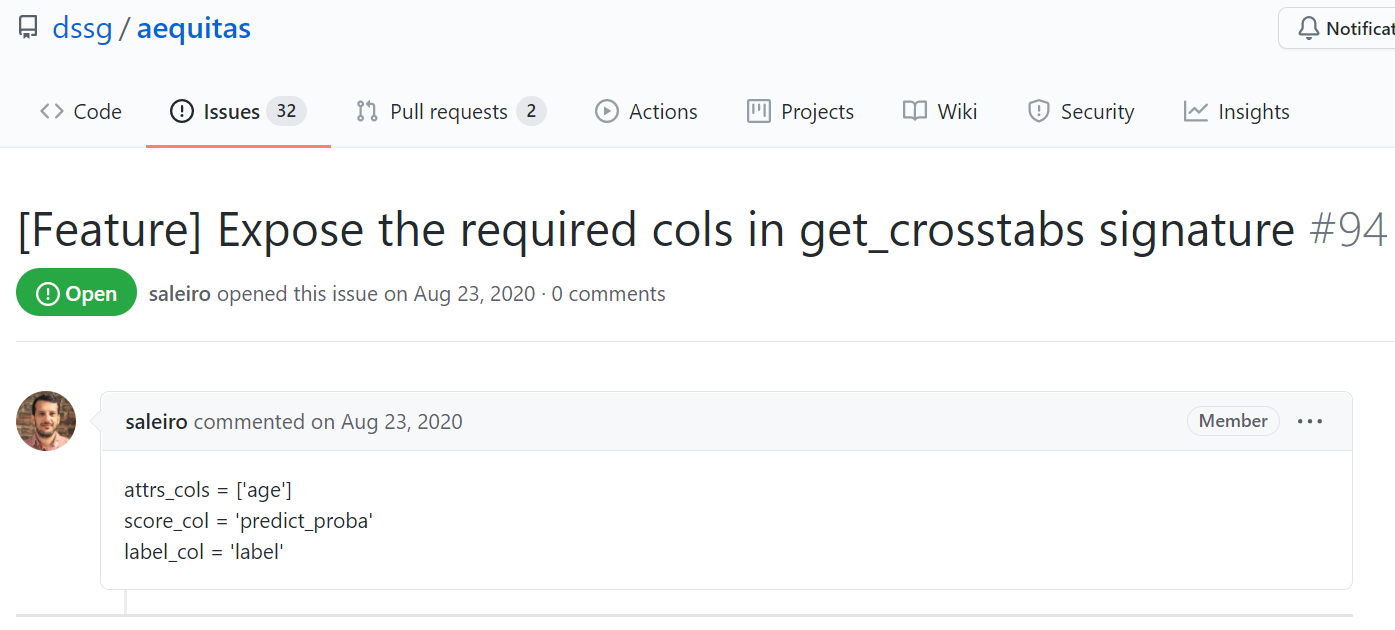

By making the change, we allowed for users to pass in dataframes that do not have already specified score amd label_value columns. This saves them time/energy because they won't have to manually rename columns for the preprocessing to work properly. 

You can see bellow, how the function can now take a dataframe with the correct column names, one with incorrect column names, and one where the user specifies what to use for score and label_value.


### preprocess_input_df
the code bellow will test the newly modified preprocess_input_df() fucntion, ensuring that it works properly. 


In [18]:
display(AQmodel.head())
AQmodel, _ = preprocess_input_df(AQmodel) # check that it works when the model already has the correct column names (score, label_value)
unnamedmodel = AQmodel.copy() # make copy of df
unnamedmodel = unnamedmodel.rename({'score': 'not_score', 'label_value': 'not_label_value'}, axis=1) # rename coluumns to incorrect names 
print('\nUnnamed Model')
display(unnamedmodel.head()) # view the new data
unnamedmodel, _ = preprocess_input_df(unnamedmodel) # should result in an error, because columns are not named correctly and we didnt pass what we want the score and label_value to be
unnamedmodel, _ = preprocess_input_df(unnamedmodel, score = 'not_score', label_value='not_label_value') # check that it works correcly when passed what the score and label_value should be
print('\nUnnamed Model After Processing')
display(unnamedmodel.head()) # view the (now processed) data, with the column names changed

,Race,Sex,Age,label_value,score,model_id
19191,White,Male,27,1,1,1
696,White,Female,29,1,1,1
12163,White,Male,64,0,0,1
3435,White,Male,50,0,1,1
27381,White,Male,50,1,1,1



Unnamed Model


,Race,Sex,Age,not_label_value,not_score,model_id
19191,White,Male,17.00-28.00,1,1,1
696,White,Female,28.00-37.00,1,1,1
12163,White,Male,48.00-90.00,0,0,1
3435,White,Male,48.00-90.00,0,1,1
27381,White,Male,48.00-90.00,1,1,1


ERROR:root:preprocessing.preprocess_input_df: input dataframe does not have all the required columns.



Unnamed Model After Processing


,Race,Sex,Age,label_value,score,model_id
19191,White,Male,17.00-28.00,0.00-1.00,0.00-1.00,1
696,White,Female,28.00-37.00,0.00-1.00,0.00-1.00,1
12163,White,Male,48.00-90.00,0.00-1.00,0.00-1.00,1
3435,White,Male,48.00-90.00,0.00-1.00,0.00-1.00,1
27381,White,Male,48.00-90.00,0.00-1.00,0.00-1.00,1


## Analysis and testing our fourth modification
Add group size adjusted false positives/negatives to calculated absolute metrics in group.py and disparity functionality in bias.py 

#### Modivation/Need

Looking on Aquitas Github repository, we saw under the Issues tab that a user had voiced concern over the tool not having capabilities to calculate group adjusted false positives and false negatives. 

Our goal was to modify functions in group.pt and bias.py so that users could use the tool to calculate the group adjusted false positive and false negative rates. 

Bellow you can see the orignal issue as commented by Github user salerio

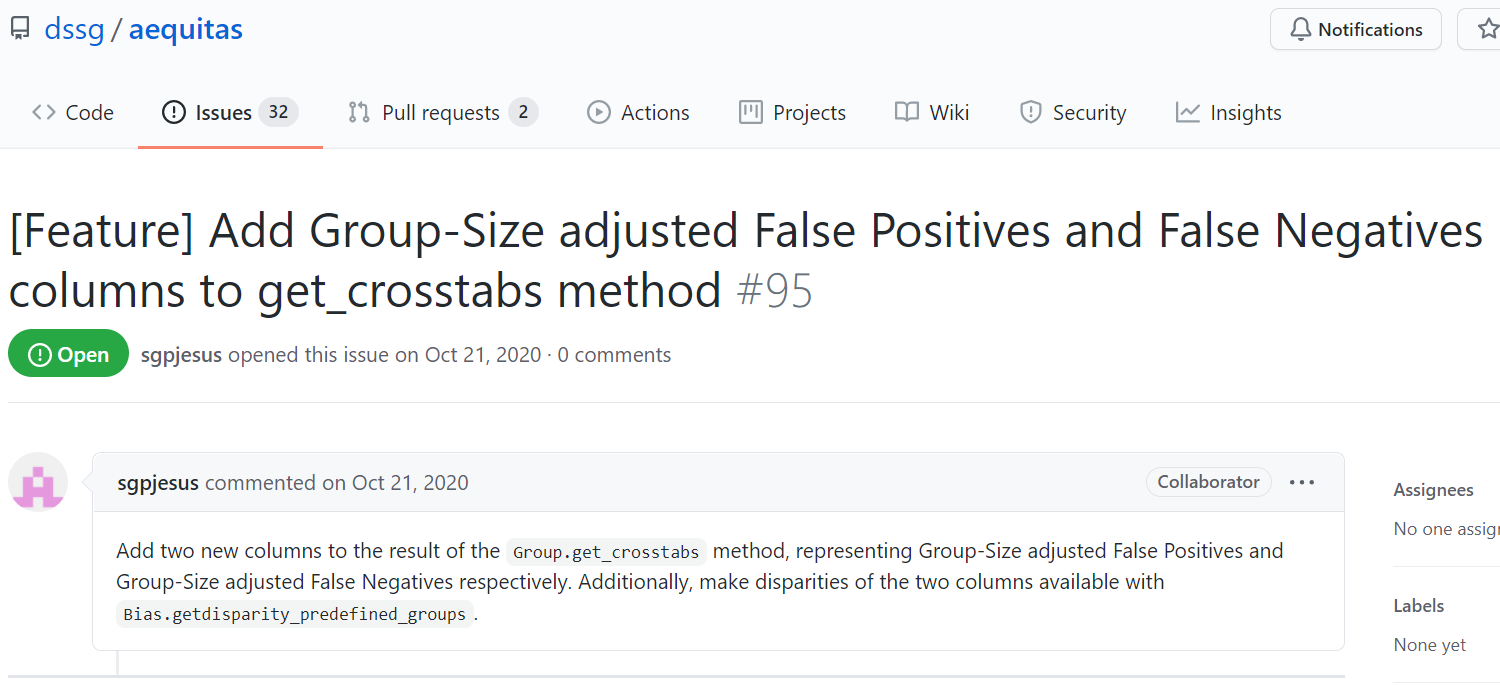

By making this change, we allowed for users of the tool to have a better measure of fairness. Now, in addition to false postive, false negative, true postive, and true negative rates, the tool can also compute group adjusted false postive and false negative rates.  

### group-adjusted false positive/negative

The code bellow prints the abosulte metrics, testing that the gafp (group adjusted false postive) and gapn (group adjusted false negative) rates appear in the table. 

In [19]:
display(xtab[['attribute_value'] + absolute_metrics].round(2)) 

,attribute_value,tpr,tnr,for,fdr,fpr,fnr,gafp,gafn,npv,precision,ppr,pprev,prev
0,Amer-Indian-Eskimo,0.96,0.36,0.43,0.08,0.64,0.04,0.07,0.03,0.57,0.92,0.01,0.93,0.88
1,Asian-Pac-Islander,0.90,0.67,0.29,0.11,0.33,0.10,0.08,0.07,0.71,0.89,0.03,0.76,0.74
2,Black,0.98,0.41,0.28,0.08,0.59,0.02,0.07,0.02,0.72,0.92,0.11,0.93,0.88
3,Other,0.96,0.38,0.38,0.10,0.62,0.04,0.09,0.03,0.62,0.90,0.01,0.91,0.85
4,White,0.93,0.60,0.26,0.13,0.40,0.07,0.10,0.05,0.74,0.87,0.84,0.79,0.75
5,Female,0.98,0.53,0.22,0.06,0.47,0.02,0.06,0.02,0.78,0.94,0.38,0.92,0.88
6,Male,0.91,0.61,0.27,0.16,0.39,0.09,0.12,0.07,0.73,0.84,0.62,0.75,0.70


Bellow is the actual code (found in bias.py) that are calcualting the rates.


---


In the bellow code snippet: 

k is the group as passed by get_crosstabs

x is an array containing total true positives/true negatives and total false positives/false negatives for that group.

The true positives/false positives and true negatives/false negatives are summed to get the size of the group. 

Then divide the false postive and false negatives by the group size.


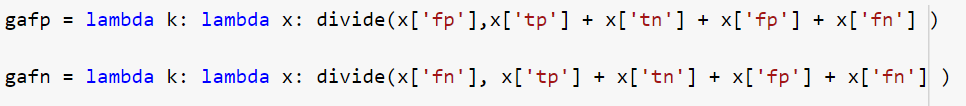

##Fairness Critera #1

  One of the biggest fairness criteria we wanted to address and evaluate was group adjusted false positive and false negatives. And we approached this by adding a function that would address the disparity metrics within our data set. Within our data set a false positive is when for one data point score = 1 and label value = 0. A false negative is when score = 0 and label value = 1. So, what a group adjusted false positive means is that, in some instances groups of individuals may be included in some category or population they don’t belong in. Thus, the term false positive. So, if I had a group of individuals that were on trial, the question becomes what the chances are they would be wrongly convicted because they were a part of a specific category or population. And our feature that we added wanted to address and highlight this disparity. 

  On the contrary a group adjusted false negative works in the opposite fashion. So, given a group of individuals on trial, an individual would be found innocent even though they were guilty. And again, our feature addresses this by highlighting the disparity within the data set. As you can see in the example above, the rates at which group adjusted false positives and negatives occur (among each group) are listed above. (Code as well as example is listed above)